In [109]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as skl_lm
import seaborn as sns
import matplotlib.gridspec as gridspec

from pandas.plotting import scatter_matrix
from statistics import mean
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D

project_folds = 10
project_random_state = 30
project_path = ''

In [83]:
%run -i Project_Functions.ipynb

## 1. Reading the Data

In this section the data is read and analysed. The dataset has 16 features and one output.

### 1.1. Download and Analize the Data

In [65]:
csv_path = project_path + 'ObesityDataSet_raw_and_data_sinthetic.csv'
dataset = pd.read_csv(csv_path)

dataset.head(10)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
7,Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
8,Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
9,Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


In [66]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

### 1.2. Converting the Object-Type Features to Numerical Ones

Some of the variables are numerical, and others are not. Converting nonnumerical data to numbers in a random way may lead to the models with bad performance.
This section represents the mapping of categorical features in the "ascending" order.
The dataset contains two types of categorical features: binary and multiple values features.
For binary features, the values are assigned as 1 for"no" and 2 for "yes".
For multiple value features, the values start from 1.
The mapping can be adjusted later.

#### The data should be converted only once, otherwise the second converting brings the numerical values to NAN

In [67]:
# Create a dictionary to map specific object values to specific numbers
mapping = {
    'Gender': {'Female': 1, 'Male': 2},
    'family_history_with_overweight': {'no': 1, 'yes': 2},
    # Frequency of high-caloric food consumption
    'FAVC': {'no': 1, 'yes': 2},
    # Consumption of food between meals
    'CAEC': {'no': 1, 'Sometimes': 2, 'Frequently': 3, 'Always': 4},
    'SMOKE': {'no': 1, 'yes': 2},
    # Calories consumption monitoring
    'SCC': {'no': 1, 'yes': 2},
    # Consumption of alcohol
    'CALC': {'no': 1, 'Sometimes': 2, 'Frequently': 3, 'Always': 4},
    # Transportation used
    'MTRANS': {'Walking': 1, 'Bike': 2, 'Motorbike': 3, 'Public_Transportation': 4, 'Automobile': 5},
    'NObeyesdad': {'Insufficient_Weight': 1, 'Normal_Weight': 2, 'Overweight_Level_I': 3, 'Overweight_Level_II': 4, 'Obesity_Type_I': 5, 'Obesity_Type_II': 6, 'Obesity_Type_III': 7}
    # Time using devices
}

# Apply the mapping to the dataset
for col, col_mapping in mapping.items():
    dataset[col] = dataset[col].map(col_mapping)
dataset['FAF'] = dataset['FAF'] + 1 
dataset['TUE'] = dataset['TUE'] + 1 
dataset.head(10)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,21.0,1.62,64.0,2,1,2.0,3.0,2,1,2.0,1,1.0,2.0,1,4,2
1,1,21.0,1.52,56.0,2,1,3.0,3.0,2,2,3.0,2,4.0,1.0,2,4,2
2,2,23.0,1.80,77.0,2,1,2.0,3.0,2,1,2.0,1,3.0,2.0,3,4,2
3,2,27.0,1.80,87.0,1,1,3.0,3.0,2,1,2.0,1,3.0,1.0,3,1,3
4,2,22.0,1.78,89.8,1,1,2.0,1.0,2,1,2.0,1,1.0,1.0,2,4,4
5,2,29.0,1.62,53.0,1,2,2.0,3.0,2,1,2.0,1,1.0,1.0,2,5,2
6,1,23.0,1.50,55.0,2,2,3.0,3.0,2,1,2.0,1,2.0,1.0,2,3,2
7,2,22.0,1.64,53.0,1,1,2.0,3.0,2,1,2.0,1,4.0,1.0,2,4,2
8,2,24.0,1.78,64.0,2,2,3.0,3.0,2,1,2.0,1,2.0,2.0,3,4,2
9,2,22.0,1.72,68.0,2,2,2.0,3.0,2,1,2.0,1,2.0,2.0,1,4,2


In [68]:
dataset.describe()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,1.505921,24.312600,1.701677,86.586058,1.817622,1.883941,2.419043,2.685628,2.140692,1.020843,2.008011,1.045476,2.010298,1.657866,1.731407,4.125059,4.112269
std,0.500083,6.345968,0.093305,26.191172,0.386247,0.320371,0.533927,0.778039,0.468543,0.142893,0.612953,0.208395,0.850592,0.608927,0.515498,0.676969,1.985062
min,1.000000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,19.947192,1.630000,65.473343,2.000000,2.000000,2.000000,2.658738,2.000000,1.000000,1.584812,1.000000,1.124505,1.000000,1.000000,4.000000,2.000000
50%,2.000000,22.777890,1.700499,83.000000,2.000000,2.000000,2.385502,3.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.625350,2.000000,4.000000,4.000000
75%,2.000000,26.000000,1.768464,107.430682,2.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.477420,1.000000,2.666678,2.000000,2.000000,4.000000,6.000000
max,2.000000,61.000000,1.980000,173.000000,2.000000,2.000000,3.000000,4.000000,4.000000,2.000000,3.000000,2.000000,4.000000,3.000000,4.000000,5.000000,7.000000


## 2. The Histograms of the Dataset 

In this part of the code the histograms of the dataset are constructed.

### 2.1. The Histogram of the Class Distribution

The dataset has 7 classes of the output 'NObeyesdad'
'Insufficient_Weight': 1,
'Normal_Weight': 2,
'Overweight_Level_I': 3,
'Overweight_Level_II': 4,
'Obesity_Type_I': 5,
'Obesity_Type_II': 6,
'Obesity_Type_III': 7}

The following histogram shows the data distribution over the classes.
The histogram reveals that the dataset is balanced.

The function next_hist allows the creation of same-type histograms for different features.

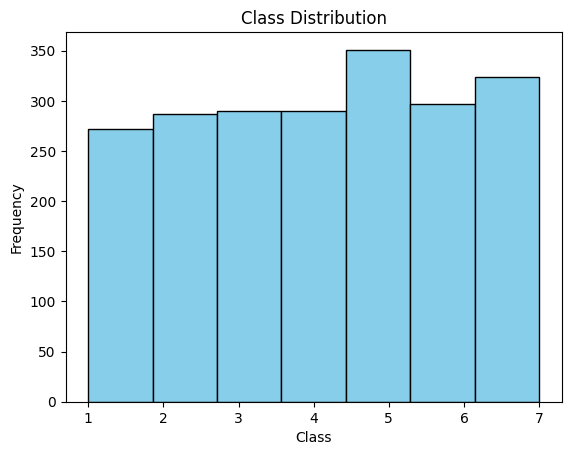

In [43]:
next_hist(1, 1, 1, dataset, 'NObeyesdad', 'Class', int(dataset['NObeyesdad'].max() - dataset['NObeyesdad'].min() + 1), 'skyblue')

### 2.2. The Histograms of the Features

The function next_hist defined above allows the creation of same-type histograms for different features.
The color of a histogram shows the type of a fueture. For numerical features, the 'skyblue' color is used.
For binary categorical features, the 'limegreen' is used. For the multi-value features, the 'salmon' is used.
All the histogram show the frequency of data distribution along the range of the corresponding feature.

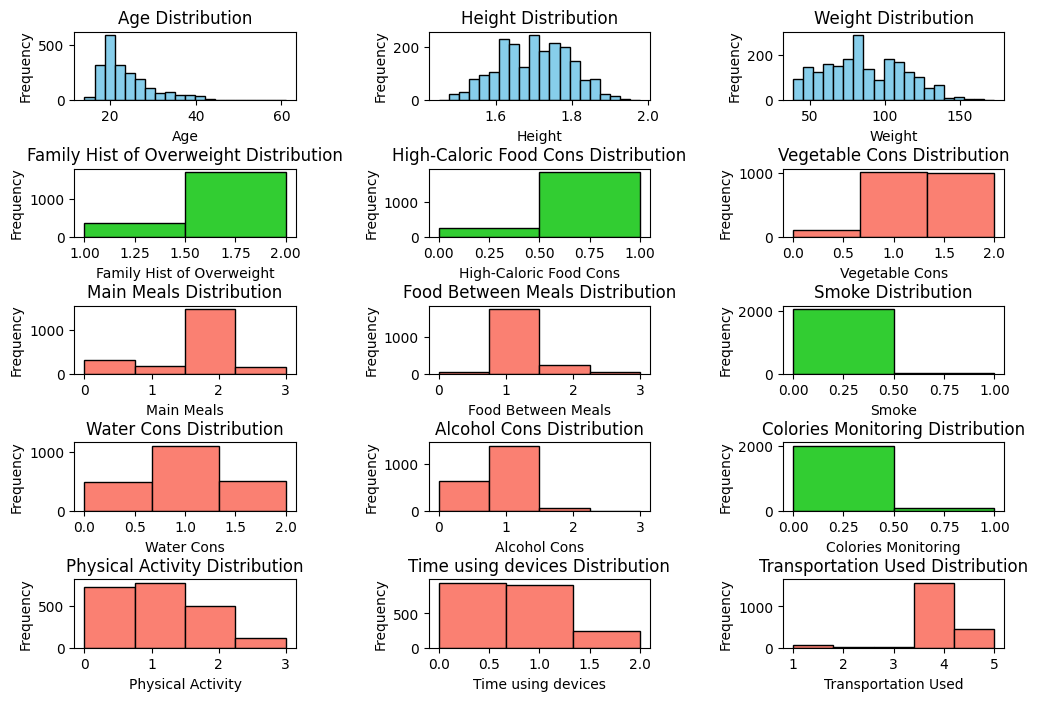

In [44]:
plt.figure(figsize = (12,8))

row = 5
col = 3

color_mult = 'skyblue'
color_binary = 'limegreen'
color_cat = 'salmon'
next_hist(row, col,  1, dataset, 'Age', 'Age', 20, color_mult)
next_hist(row, col,  2, dataset, 'Height', 'Height', 20, color_mult)
next_hist(row, col,  3, dataset, 'Weight', 'Weight', 20, color_mult)
next_hist(row, col,  4, dataset, 'family_history_with_overweight', 'Family Hist of Overweight',
         int(dataset['family_history_with_overweight'].max() - dataset['family_history_with_overweight'].min() + 1), color_binary)
next_hist(row, col,  5, dataset, 'FAVC', 'High-Caloric Food Cons', int(dataset['FAVC'].max() - dataset['FAVC'].min() + 1), color_binary)
next_hist(row, col,  6, dataset, 'FCVC', 'Vegetable Cons', int(dataset['FCVC'].max() - dataset['FCVC'].min() + 1), color_cat)
next_hist(row, col,  7, dataset, 'NCP', 'Main Meals', int(dataset['NCP'].max() - dataset['NCP'].min() + 1), color_cat)
next_hist(row, col,  8, dataset, 'CAEC', 'Food Between Meals', int(dataset['CAEC'].max() - dataset['CAEC'].min() + 1), color_cat)
next_hist(row, col,  9, dataset, 'SMOKE', 'Smoke', int(dataset['SMOKE'].max() - dataset['SMOKE'].min() + 1), color_binary)
next_hist(row, col, 10, dataset, 'CH2O', 'Water Cons', int(dataset['CH2O'].max() - dataset['CH2O'].min() + 1), color_cat)
next_hist(row, col, 11, dataset, 'CALC', 'Alcohol Cons', int(dataset['CALC'].max() - dataset['CALC'].min() + 1), color_cat)
next_hist(row, col, 12, dataset, 'SCC', 'Colories Monitoring', int(dataset['SCC'].max() - dataset['SCC'].min() + 1), color_binary)
next_hist(row, col, 13, dataset, 'FAF', 'Physical Activity', int(dataset['FAF'].max() - dataset['FAF'].min() + 1), color_cat)
next_hist(row, col, 14, dataset, 'TUE', 'Time using devices', int(dataset['TUE'].max() - dataset['TUE'].min() + 1), color_cat)
next_hist(row, col, 15, dataset, 'MTRANS', 'Transportation Used', int(dataset['MTRANS'].max() - dataset['MTRANS'].min() + 1), color_cat)


# Adjust spacing between subplots
plt.subplots_adjust(hspace = 1.0, wspace = 0.6)  # Increase the value to increase spacing
plt.show()


## 3. The Correlation Matrix and Scatter Plots

The dataset has 16 features. To identify the correlated features, the correlation matrix was calculated. There were identified only the correlations that are greater than the threshold = 0.28. The scatter plots of the most correlated features are given.

### 3.1. The Correlation Matrix

In [12]:
# Calculate the correlation matrix
corr_matrix = dataset.corr()
print(corr_matrix.shape)

# Set a threshold (replace with your desired threshold)
threshold = 0.29

# Find indices where correlation coefficients are greater than the threshold
row_indices, col_indices = np.where((abs(np.triu(corr_matrix, k=1)) > threshold)&(np.triu(corr_matrix, k=1) != 1))

# Get the actual values corresponding to these indices
values = corr_matrix.values[row_indices, col_indices]

print(f"Indices of elements with abs val greater than {threshold}:")
print(f"Row    indices: {row_indices}")
print(f"Column indices: {col_indices}")
print(f"Values greater than {threshold}: {values}")
print()
print(dataset.info())
#print(corr_matrix)

(17, 17)
Indices of elements with abs val greater than 0.29:
Row    indices: [0 1 1 2 2 3 3 4 8]
Column indices: [ 2 13 15  3 12  4 16 16 16]
Values greater than 0.29: [ 0.6184663  -0.29693059  0.41010185  0.46313612  0.294709    0.49682038
  0.9132508   0.50514842 -0.32934972]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   int64  
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   int64  
 5   FAVC                            2111 non-null   int64  
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8 

In [13]:
corr_matrix

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
Gender,1.000000,0.048394,0.618466,0.161668,0.102512,0.064934,-0.274505,0.067600,-0.091543,0.044698,0.107930,-0.102633,0.189607,0.017269,-0.007616,0.041209,-0.031464
Age,0.048394,1.000000,-0.025958,0.202560,0.205725,0.063902,0.016291,-0.043944,-0.083739,0.091987,-0.045304,-0.116283,-0.144938,-0.296931,0.044487,0.410102,0.282913
Height,0.618466,-0.025958,1.000000,0.463136,0.247684,0.178364,-0.038121,0.243672,-0.048818,0.055499,0.213376,-0.133753,0.294709,0.051912,0.129732,0.017241,0.133565
Weight,0.161668,0.202560,0.463136,1.000000,0.496820,0.272300,0.216125,0.107469,-0.287493,0.025746,0.200575,-0.201906,-0.051436,-0.071561,0.206677,0.071179,0.913251
family_history_with_overweight,0.102512,0.205725,0.247684,0.496820,1.000000,0.208036,0.040372,0.071370,-0.169787,0.017385,0.147437,-0.185422,-0.056673,0.022943,-0.036676,0.116269,0.505148
FAVC,0.064934,0.063902,0.178364,0.272300,0.208036,1.000000,-0.027283,-0.007000,-0.150068,-0.050660,0.009719,-0.190658,-0.107995,0.068417,0.089520,0.180586,0.247793
FCVC,-0.274505,0.016291,-0.038121,0.216125,0.040372,-0.027283,1.000000,0.042216,0.054670,0.014320,0.068461,0.071852,0.019939,-0.101135,0.060781,-0.041246,0.227759
NCP,0.067600,-0.043944,0.243672,0.107469,0.071370,-0.007000,0.042216,1.000000,0.097801,0.007811,0.057088,-0.015624,0.129504,0.036326,0.071747,0.023505,0.026690
CAEC,-0.091543,-0.083739,-0.048818,-0.287493,-0.169787,-0.150068,0.054670,0.097801,1.000000,0.055282,-0.144995,0.109179,0.030110,0.048567,-0.047540,-0.097334,-0.329350
SMOKE,0.044698,0.091987,0.055499,0.025746,0.017385,-0.050660,0.014320,0.007811,0.055282,1.000000,-0.031995,0.047731,0.011216,0.017613,0.082471,-0.007362,0.003442


### 3.2. The Scatter Plots of the Most Correlated Ffeatures

The investigation of the scatter plots reveals a strange behavior of some features. For example, the feature 'TUE' (time using devices} is categorical. This is a numerical feature with three possible values: 0 for 0-2 hours, 1 for 
3-5 hours and 2 for 
More than 5 hou. However, the scatter plot shows  the decimal values because this feature was treated not as categorical. It was written in the dataset as numerical, and later the dataset was expanded with artificial data points.
In the scatter plot section of the code, the function next_scatter is used to avoid the repetition for each pair of features.s


##### The legend adjustment
Upper Right (loc=1): The legend will be placed in the upper right corner.
Upper Left (loc=2): The legend will be placed in the upper left corner.
Lower Left (loc=3): The legend will be placed in the lower left corner.
Lower Right (loc=4): The legend will be placed in the lower right corner.
Right (loc=5): The legend will be placed on the right side.
Center Left (loc=6): The legend will be placed in the center of the left side.
Center Right (loc=7): The legend will be placed in the center of the right side.
Lower Center (loc=8): The legend will be placed at the bottom center.
Upper Center (loc=9): The legend will be placed at the top center.
Center (loc=10): The legend will be placed in the center of the plot.

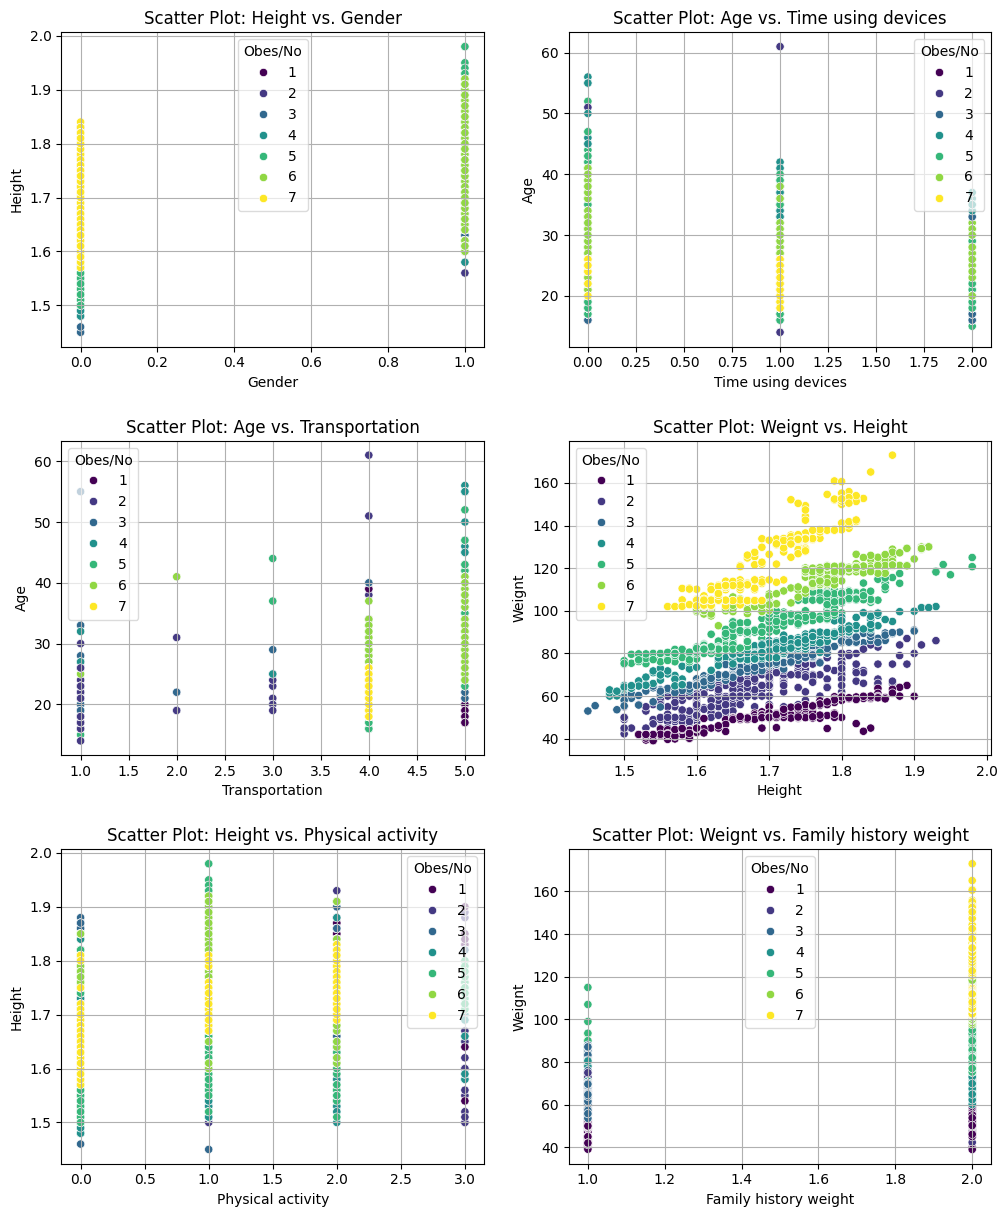

In [50]:
plt.figure(figsize = (12, 20))
hue = dataset['NObeyesdad']
row = 4
col = 2
next_scatter(row, col, 1, dataset['Gender'], dataset['Height'], hue, 'Gender', 'Height', 9)
next_scatter(row, col, 2, dataset['TUE'], dataset['Age'], hue, 'Time using devices', 'Age', 1)
next_scatter(row, col, 3, dataset['MTRANS'], dataset['Age'], hue, 'Transportation', 'Age', 2)
next_scatter(row, col, 4, dataset['Height'], dataset['Weight'], hue, 'Height', 'Weignt', 2)
next_scatter(row, col, 5, dataset['FAF'], dataset['Height'], hue, 'Physical activity', 'Height', 1)
#next_scatter(row, col, 6, dataset['TUE'], dataset['Height'], hue, 'Time using devices', 'Height', 1)
next_scatter(row, col, 6, dataset['family_history_with_overweight'], dataset['Weight'], hue, 'Family history weight', 'Weignt', 9)
#next_scatter(row, col, 8, dataset['CAEC'], dataset['Weight'], hue, 'Food Between Meal', 'Weignt', 1)
# Adjust spacing between subplots
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)  # Increase the value to increase spacing
plt.show()

### 3.3. The Scatter Plots of the Features which are Correlated to the Output the Most

The scatter plots of binary and multi-value features are not informative. The shape of these graphs gave an idea of providing the feature distribution among classes.

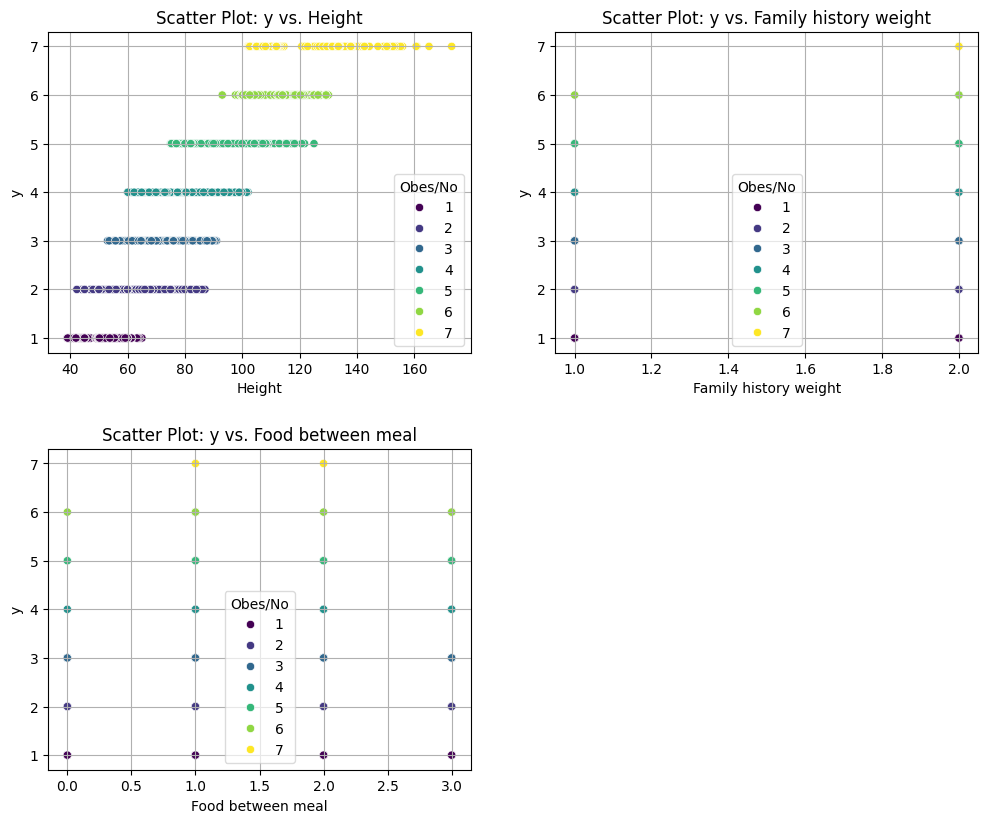

In [51]:
plt.figure(figsize = (12, 15))
output = dataset['NObeyesdad']
row = 3
col = 2

next_scatter(row, col, 3, dataset['Weight'], output, output, 'Height', 'y', 4)
next_scatter(row, col, 4, dataset['family_history_with_overweight'], output, output, 'Family history weight', 'y', 8)
next_scatter(row, col, 5, dataset['CAEC'], output, output, 'Food between meal', 'y', 8)

plt.subplots_adjust(hspace = 0.3, wspace = 0.2)  # Increase the value to increase spacing
plt.show()

### 3.4. The Scatter Plots of the Other Features

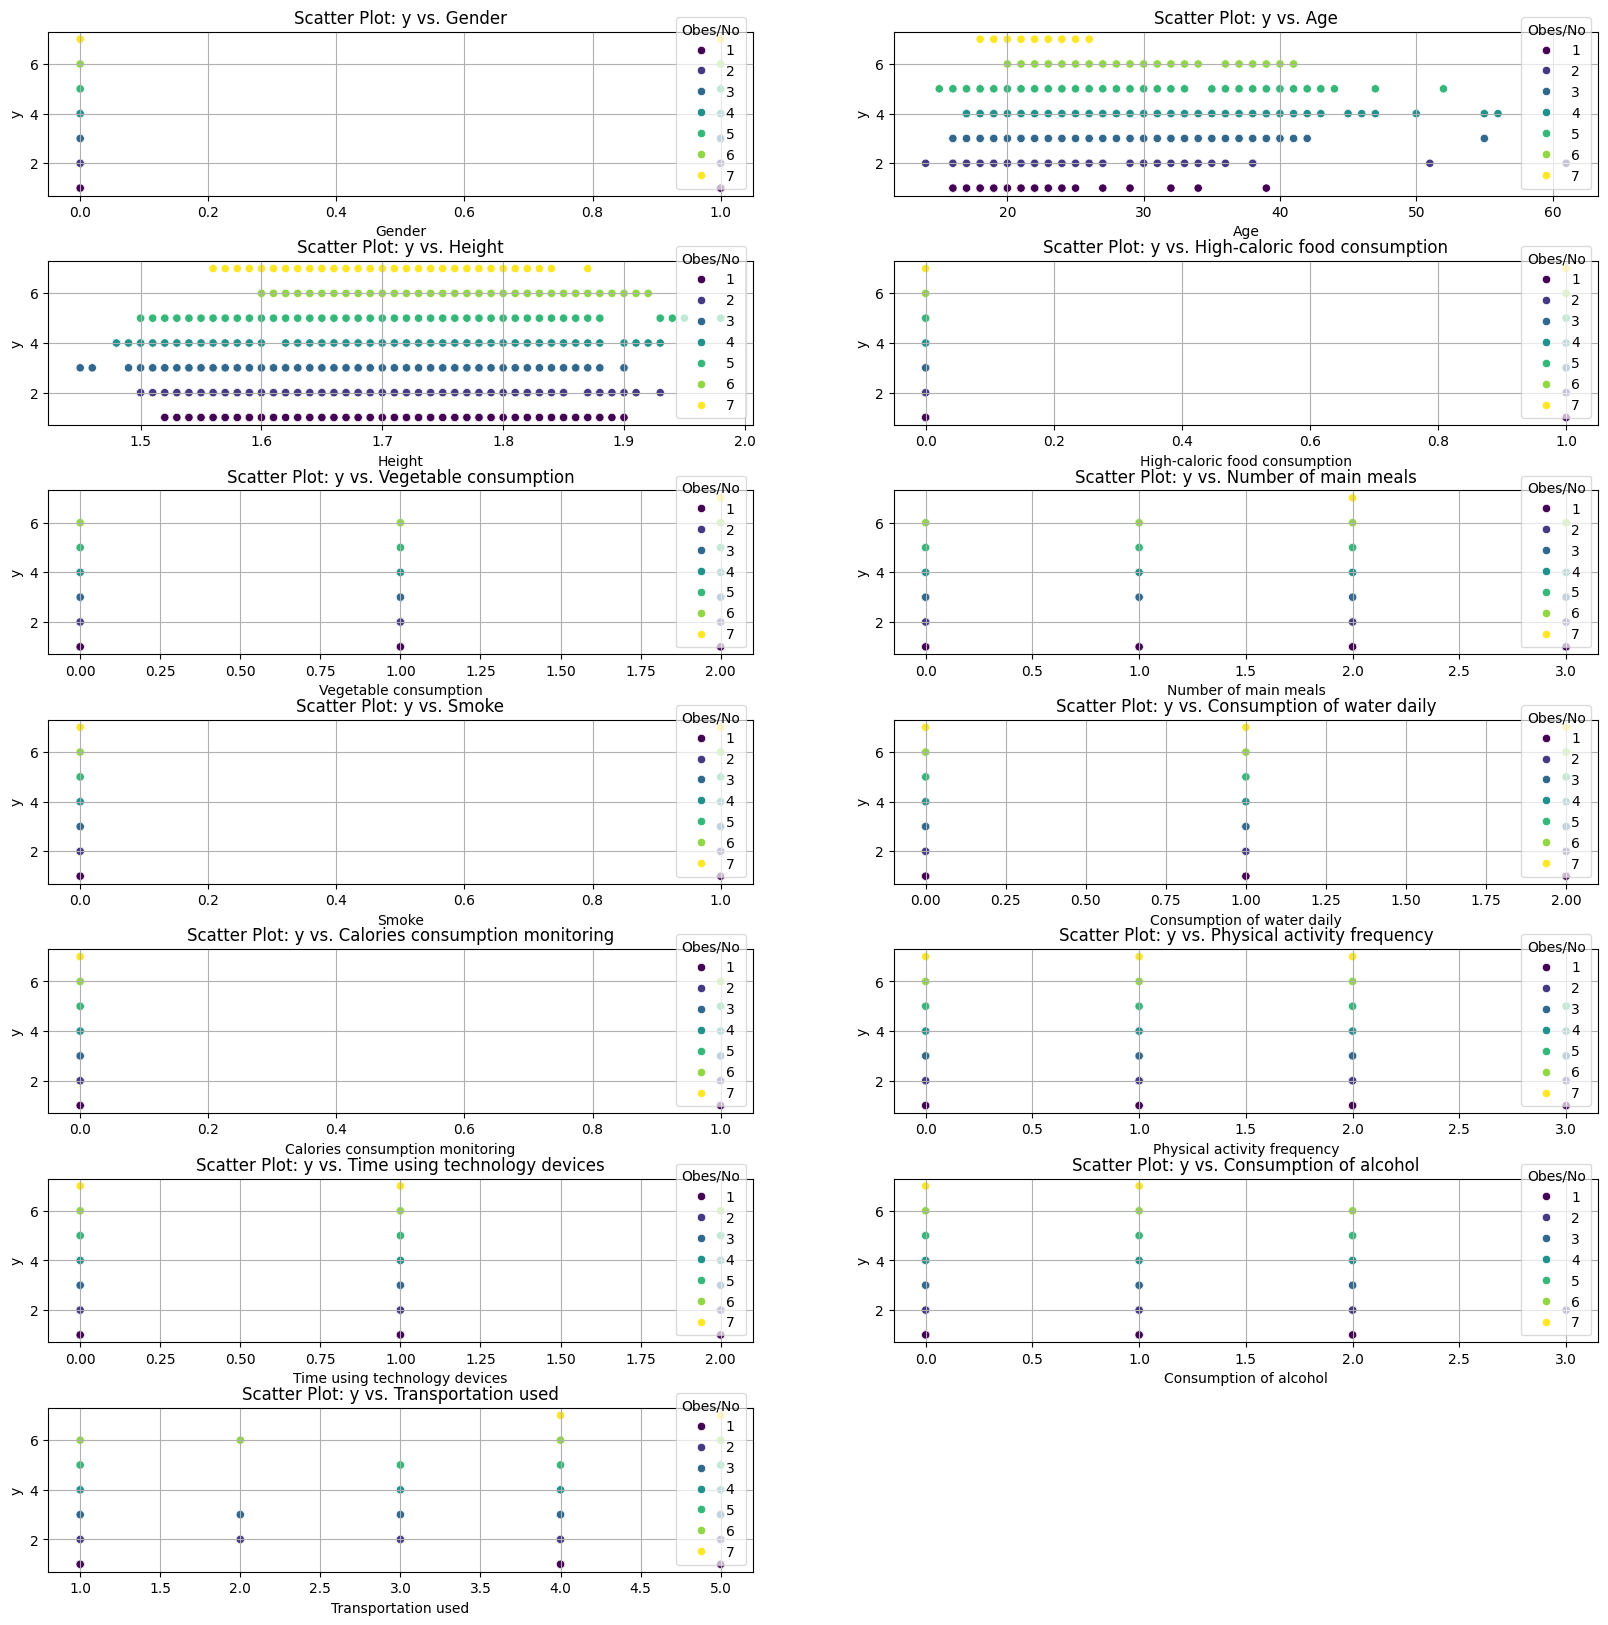

In [52]:
plt.figure(figsize = (20, 20))
output = dataset['NObeyesdad']
row = 7
col = 2
next_scatter(row, col,  1, dataset['Gender'], output, output, 'Gender', 'y', 4)
next_scatter(row, col,  2, dataset['Age'], output, output, 'Age', 'y', 4)
next_scatter(row, col,  3, dataset['Height'], output, output, 'Height', 'y', 4)
next_scatter(row, col,  4, dataset['FAVC'], output, output, 'High-caloric food consumption', 'y', 4)
next_scatter(row, col,  5, dataset['FCVC'], output, output, 'Vegetable consumption', 'y', 4)
next_scatter(row, col,  6, dataset['NCP'], output, output, 'Number of main meals', 'y', 4)
next_scatter(row, col,  7, dataset['SMOKE'], output, output, 'Smoke', 'y', 4)
next_scatter(row, col,  8, dataset['CH2O'], output, output, 'Consumption of water daily', 'y', 4)
next_scatter(row, col,  9, dataset['SCC'], output, output, 'Calories consumption monitoring', 'y', 4)
next_scatter(row, col, 10, dataset['FAF'], output, output, 'Physical activity frequency', 'y', 4)
next_scatter(row, col, 11, dataset['TUE'], output, output, 'Time using technology devices', 'y', 4)
next_scatter(row, col, 12, dataset['CALC'], output, output, 'Consumption of alcohol', 'y', 4)
next_scatter(row, col, 13, dataset['MTRANS'], output, output, 'Transportation used', 'y', 4)
# Adjust spacing between subplots
plt.subplots_adjust(hspace = 0.4, wspace = 0.2)  # Increase the value to increase spacing
plt.show()

## 4. The Features Distribution between Classes

In this section, the feature distribution over the classes is given.
The hot encoder is involved in obtaining the matrix of the feature distribution.
For categorical features, the number of bins corresponds to the number of categories.
For the numerical features, the number of bins can be adjusted.

### 4.1. The Histograms of Feature Distribution

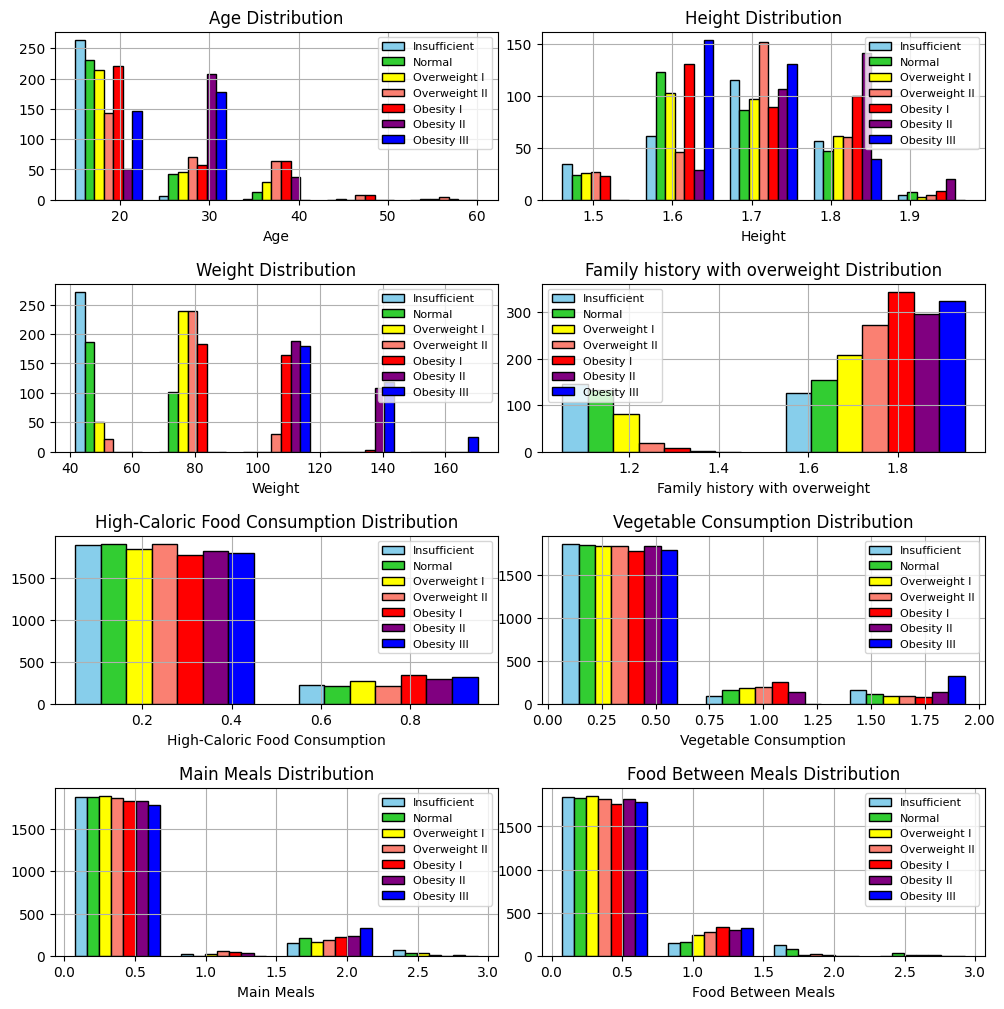

In [55]:
plt.figure(figsize = (12,12))
cat_encoder, NObeyesdad_cat_1hot = get_hot_encoder(dataset)

row = 4
col = 2
colors = ['skyblue', 'limegreen', 'yellow', 'salmon', 'red', 'purple', 'blue']
#labels = ['Insufficient weight', 'Normal weight', 'Overweight Level I', 'Overweight Level II', 'Obesity Type I', 'Obesity Type II', 'Obesity Type III']
labels = ['Insufficient', 'Normal', 'Overweight I', 'Overweight II', 'Obesity I', 'Obesity II', 'Obesity III']

next_hist_multi(row, col,  1, dataset, multiply_feature_by_one_hot(dataset, 'Age', cat_encoder, NObeyesdad_cat_1hot),
                'Age', 'Age', 5, colors, labels)
next_hist_multi(row, col,  2, dataset, multiply_feature_by_one_hot(dataset, 'Height', cat_encoder, NObeyesdad_cat_1hot), 'Height',
                'Height', 5, colors, labels)
next_hist_multi(row, col,  3, dataset, multiply_feature_by_one_hot(dataset, 'Weight', cat_encoder, NObeyesdad_cat_1hot), 'Weight',
                'Weight', 5, colors, labels)
next_hist_multi(row, col,  4, dataset, multiply_feature_by_one_hot(dataset, 'family_history_with_overweight', cat_encoder, NObeyesdad_cat_1hot),
                'family_history_with_overweight', 'Family history with overweight', 2, colors, labels)
next_hist_multi(row, col,  5, dataset, multiply_feature_by_one_hot(dataset, 'FAVC', cat_encoder, NObeyesdad_cat_1hot),
                'FAVC', 'High-Caloric Food Consumption', 2, colors, labels)
next_hist_multi(row, col,  6, dataset, multiply_feature_by_one_hot(dataset, 'FCVC', cat_encoder, NObeyesdad_cat_1hot), 
                'FCVC', 'Vegetable Consumption', 3, colors, labels)
next_hist_multi(row, col,  7, dataset, multiply_feature_by_one_hot(dataset, 'NCP', cat_encoder, NObeyesdad_cat_1hot),
                'NCP', 'Main Meals', 4, colors, labels)
next_hist_multi(row, col,  8, dataset, multiply_feature_by_one_hot(dataset, 'CAEC', cat_encoder, NObeyesdad_cat_1hot),
                'CAEC', 'Food Between Meals', 4, colors, labels)

plt.subplots_adjust(hspace = 0.5, wspace = 0.1)  # Increase the value to increase spacing
plt.show()

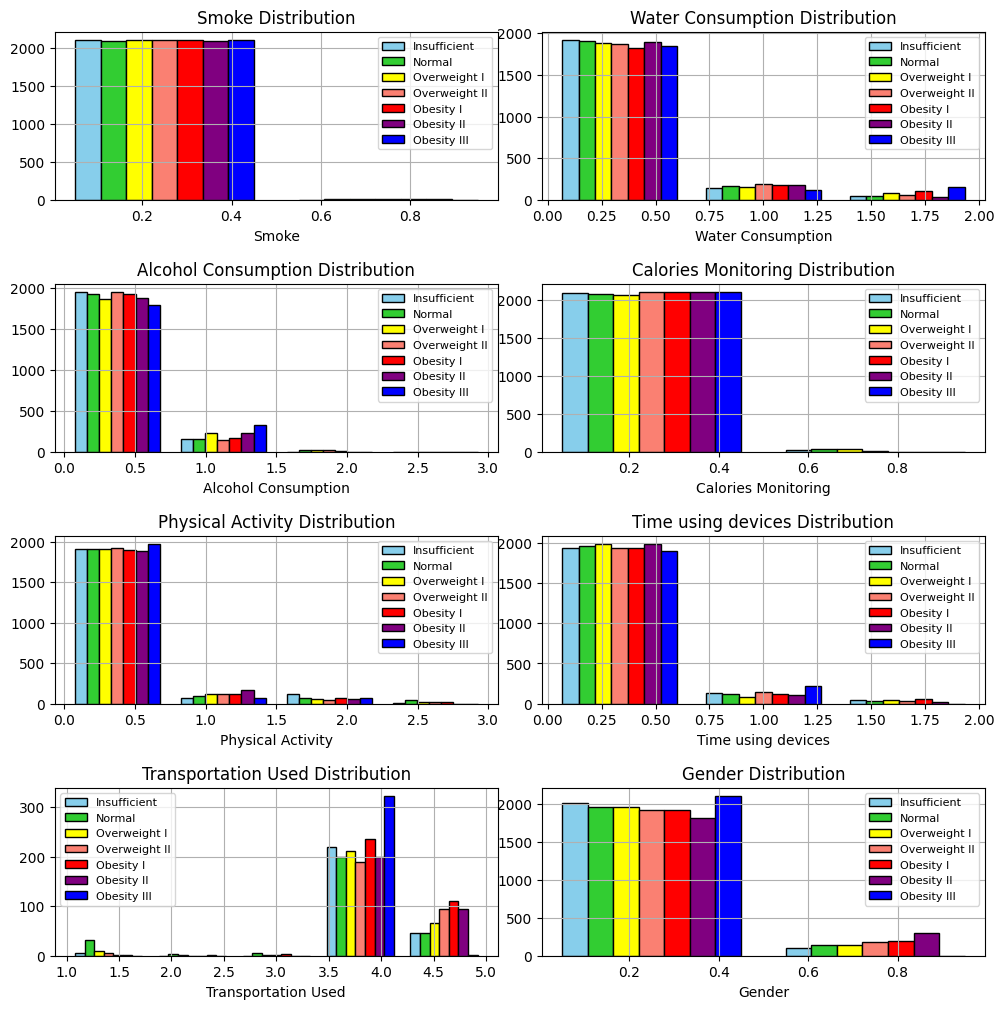

In [56]:
plt.figure(figsize = (12,12))

next_hist_multi(row, col, 1, dataset, multiply_feature_by_one_hot(dataset, 'SMOKE', cat_encoder, NObeyesdad_cat_1hot), 
                'SMOKE', 'Smoke', 2, colors, labels)
next_hist_multi(row, col, 2, dataset, multiply_feature_by_one_hot(dataset, 'CH2O', cat_encoder, NObeyesdad_cat_1hot),
                'CH2O', 'Water Consumption', 3, colors, labels)
next_hist_multi(row, col, 3, dataset, multiply_feature_by_one_hot(dataset, 'CALC', cat_encoder, NObeyesdad_cat_1hot),
                'CALC', 'Alcohol Consumption', 4, colors, labels)
next_hist_multi(row, col, 4, dataset, multiply_feature_by_one_hot(dataset, 'SCC', cat_encoder, NObeyesdad_cat_1hot), 
                'SCC', 'Calories Monitoring', 2, colors, labels)
next_hist_multi(row, col, 5, dataset, multiply_feature_by_one_hot(dataset, 'FAF', cat_encoder, NObeyesdad_cat_1hot),
                'FAF', 'Physical Activity', 4, colors, labels)
next_hist_multi(row, col, 6, dataset, multiply_feature_by_one_hot(dataset, 'TUE', cat_encoder, NObeyesdad_cat_1hot),
                'TUE', 'Time using devices', 3, colors, labels)
next_hist_multi(row, col, 7, dataset, multiply_feature_by_one_hot(dataset, 'MTRANS', cat_encoder, NObeyesdad_cat_1hot), 
                'MTRANS', 'Transportation Used', 5, colors, labels)
next_hist_multi(row, col, 8, dataset, multiply_feature_by_one_hot(dataset, 'Gender', cat_encoder, NObeyesdad_cat_1hot), 
                'Gender', 'Gender', 2, colors, labels)

plt.subplots_adjust(hspace = 0.5, wspace = 0.1)  # Increase the value to increase spacing
plt.show()

### 4.2. The Boxplots of Features

In this section, the boxplots for different features are shown.

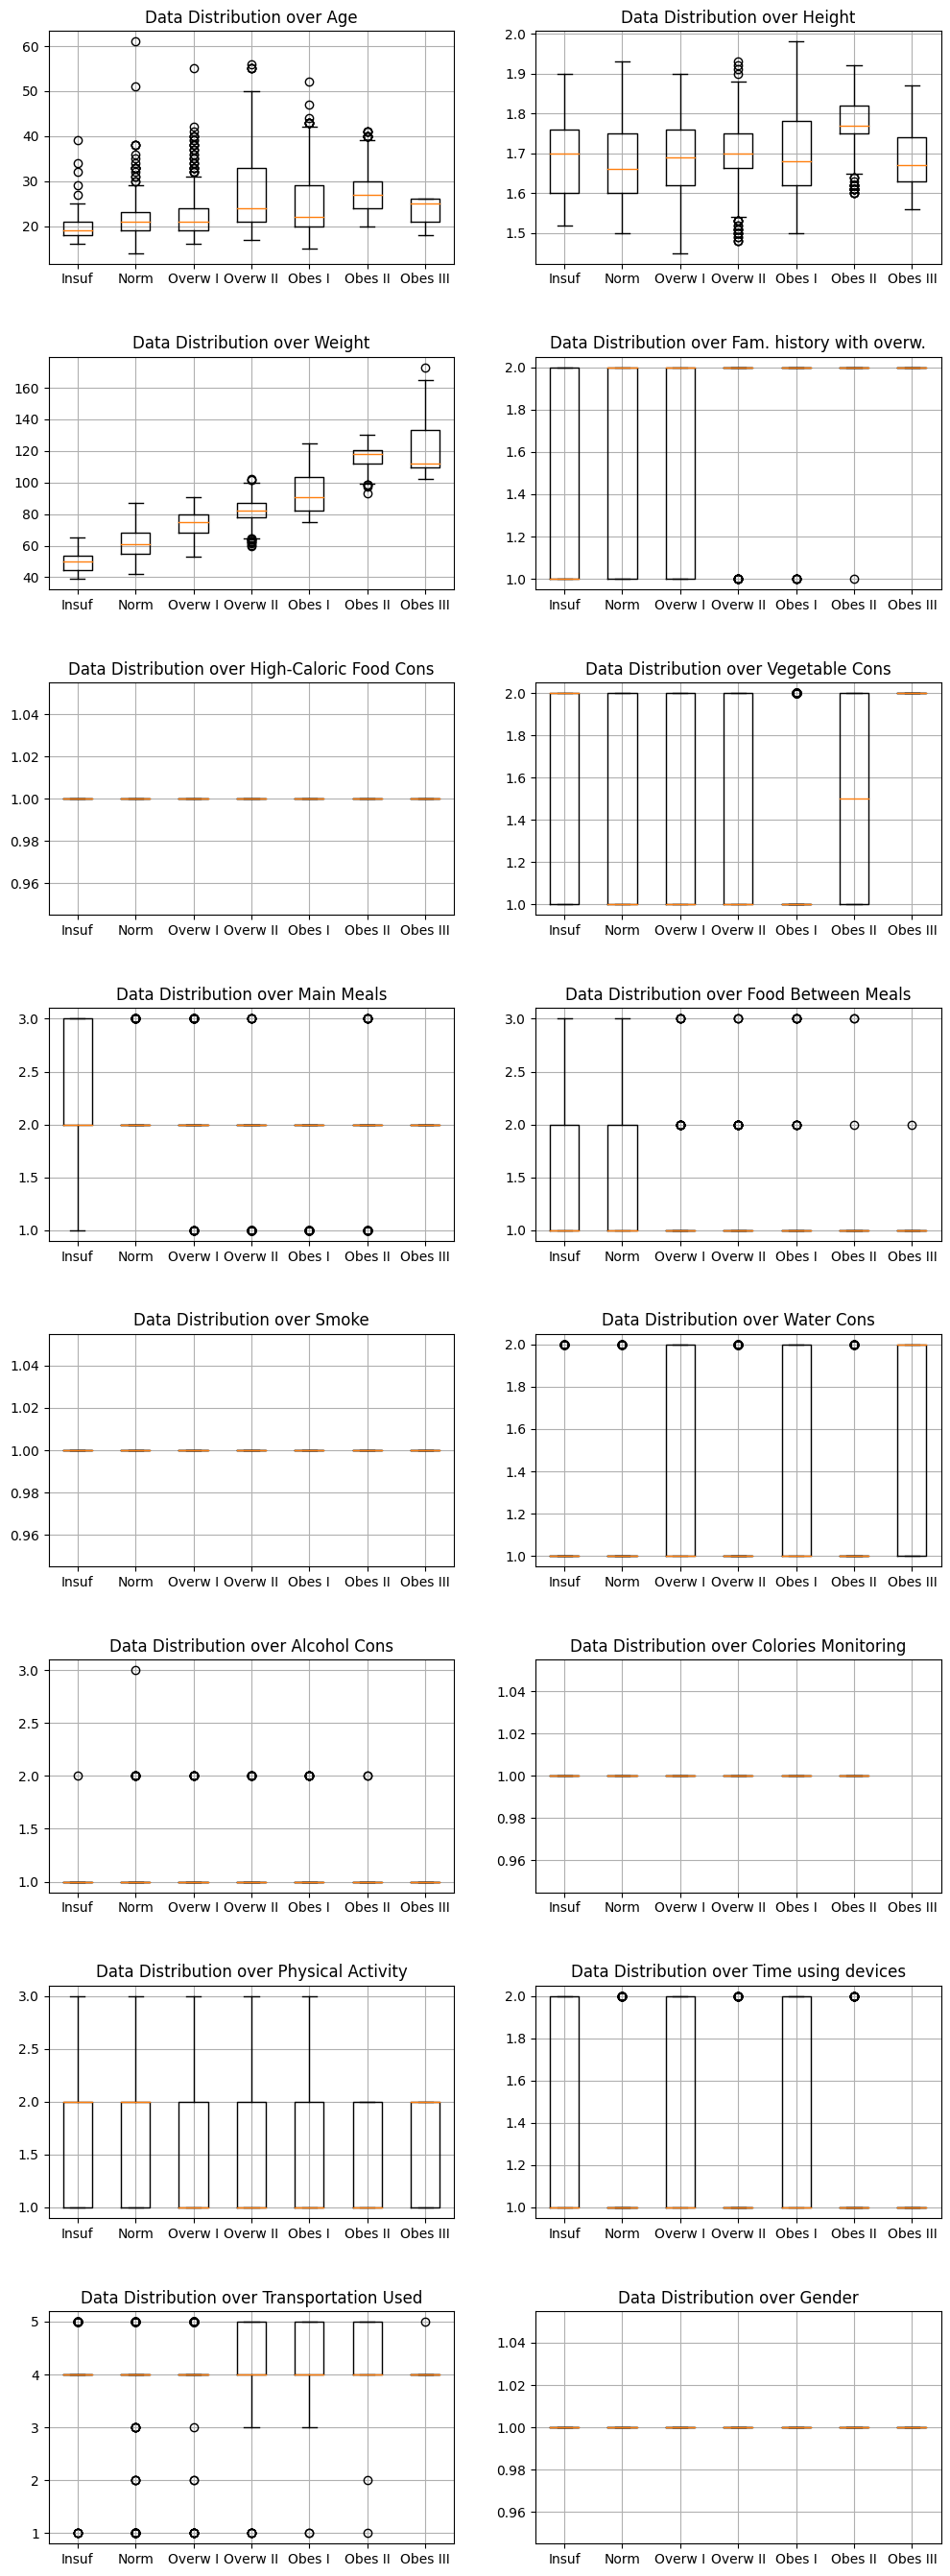

In [59]:
plt.figure(figsize = (12,34))
cat_encoder, NObeyesdad_cat_1hot = get_hot_encoder(dataset)

row = 8
col = 2
colors = ['skyblue', 'limegreen', 'yellow', 'salmon', 'red', 'purple', 'blue']
#labels = ['Insufficient weight', 'Normal weight', 'Overweight Level I', 'Overweight Level II', 'Obesity Type I', 'Obesity Type II', 'Obesity Type III']
labels = ['Insuf', 'Norm', 'Overw I', 'Overw II', 'Obes I', 'Obes II', 'Obes III']

next_boxplot_multi(row, col,  1, multiply_feature_by_one_hot(dataset, 'Age', cat_encoder, NObeyesdad_cat_1hot),
                   'Age', 'Age', labels)
next_boxplot_multi(row, col,  2, multiply_feature_by_one_hot(dataset, 'Height', cat_encoder, NObeyesdad_cat_1hot),
                   'Height', 'Height', labels)
next_boxplot_multi(row, col,  3, multiply_feature_by_one_hot(dataset, 'Weight', cat_encoder, NObeyesdad_cat_1hot),
                   'Weight', 'Weight', labels)
next_boxplot_multi(row, col,  4, multiply_feature_by_one_hot(dataset, 'family_history_with_overweight', cat_encoder, NObeyesdad_cat_1hot),
                   'family_history_with_overweight', 'Fam. history with overw.', labels)
next_boxplot_multi(row, col,  5, multiply_feature_by_one_hot(dataset, 'FAVC', cat_encoder, NObeyesdad_cat_1hot),
                'FAVC', 'High-Caloric Food Cons', labels)
next_boxplot_multi(row, col,  6, multiply_feature_by_one_hot(dataset, 'FCVC', cat_encoder, NObeyesdad_cat_1hot), 
                'FCVC', 'Vegetable Cons', labels)
next_boxplot_multi(row, col,  7, multiply_feature_by_one_hot(dataset, 'NCP', cat_encoder, NObeyesdad_cat_1hot),
                'NCP', 'Main Meals', labels)
next_boxplot_multi(row, col,  8, multiply_feature_by_one_hot(dataset, 'CAEC', cat_encoder, NObeyesdad_cat_1hot),
                'CAEC', 'Food Between Meals', labels)
next_boxplot_multi(row, col,  9, multiply_feature_by_one_hot(dataset, 'SMOKE', cat_encoder, NObeyesdad_cat_1hot), 
                'SMOKE', 'Smoke', labels)
next_boxplot_multi(row, col, 10, multiply_feature_by_one_hot(dataset, 'CH2O', cat_encoder, NObeyesdad_cat_1hot),
                'CH2O', 'Water Cons', labels)
next_boxplot_multi(row, col, 11, multiply_feature_by_one_hot(dataset, 'CALC', cat_encoder, NObeyesdad_cat_1hot),
                'CALC', 'Alcohol Cons', labels)
next_boxplot_multi(row, col, 12, multiply_feature_by_one_hot(dataset, 'SCC', cat_encoder, NObeyesdad_cat_1hot), 
                'SCC', 'Colories Monitoring', labels)
next_boxplot_multi(row, col, 13, multiply_feature_by_one_hot(dataset, 'FAF', cat_encoder, NObeyesdad_cat_1hot),
                'FAF', 'Physical Activity', labels)
next_boxplot_multi(row, col, 14, multiply_feature_by_one_hot(dataset, 'TUE', cat_encoder, NObeyesdad_cat_1hot),
                'TUE', 'Time using devices', labels)
next_boxplot_multi(row, col, 15, multiply_feature_by_one_hot(dataset, 'MTRANS', cat_encoder, NObeyesdad_cat_1hot), 
                'MTRANS', 'Transportation Used', labels)
next_boxplot_multi(row, col, 16, multiply_feature_by_one_hot(dataset, 'Gender', cat_encoder, NObeyesdad_cat_1hot), 
                'Gender', 'Gender', labels)

plt.subplots_adjust(hspace = 0.4, wspace = 0.2)  # Increase the value to increase spacing
plt.show()

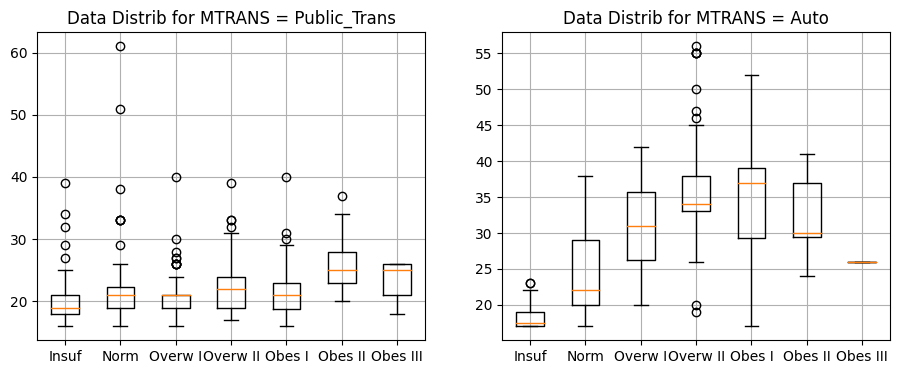

In [62]:
plt.figure(figsize = (11,4))
# Boxplot of Age vs NObeyesdad for MTRANS = 'public transportation'
public_trans = dataset.loc[dataset['MTRANS'] == 4]
plt.subplot(1,2,1)
box_plot_zoom(public_trans, 'Age', 'NObeyesdad', labels, 'Data Distrib for MTRANS = Public_Trans')

# Boxplot of Age vs NObeyesdad for MTRANS = 'automobile'
public_trans = dataset.loc[dataset['MTRANS'] == 5]
plt.subplot(1,2,2)
box_plot_zoom(public_trans, 'Age', 'NObeyesdad', labels, 'Data Distrib for MTRANS = Auto')
plt.show()

## 5. Dataset Transformation and Splitting

In this section, the data is transformed and slpitting.
The rows from 0 to 497 are real. The rest of the rows are synthesized.
Set aside the columns with decimal data.
Convert the numbers to an appropriate format.

### 5.1. Data Transformation

In previous sections, zeros were excluded because of the each value multiplying by the matrix obtained using one hot encoder. This was done to calculate the number of each class representative for histograms. In this section, the data is preprocessed for model development, and the sets of values start from 0.

In [69]:
dataset['Gender']   = dataset['Gender'] - 1
dataset['FAVC']     = dataset['FAVC'] - 1
dataset['CAEC']     = dataset['CAEC'] - 1
dataset['SMOKE']    = dataset['SMOKE'] - 1
dataset['SCC']      = dataset['SCC'] - 1
dataset['CALC']     = dataset['CALC'] - 1

dataset['Age_1']    = dataset['Age']
dataset['Age']      = dataset['Age_1'] // 1
dataset['Height_1'] = dataset['Height']
dataset['Height']   = dataset['Height_1'].round(decimals = 2)
dataset['Weight_1'] = dataset['Weight']
dataset['Weight']   = dataset['Weight_1'].round(decimals = 1)
dataset['FCVC_1']   = dataset['FCVC'] - 1
dataset['FCVC']     = dataset['FCVC_1'].round(decimals = 0)
dataset['NCP_1']    = dataset['NCP'] - 1
dataset['NCP']      = dataset['NCP_1'].round(decimals = 0)
dataset['CH2O_1']   = dataset['CH2O'] - 1
dataset['CH2O']     = dataset['CH2O_1'].round(decimals = 0)
dataset['FAF_1']    = dataset['FAF'] - 1
dataset['FAF']      = dataset['FAF_1'].round(decimals = 0)
dataset['TUE_1']    = dataset['TUE'] - 1
dataset['TUE']      = dataset['TUE_1'].round(decimals = 0)

In [70]:
dataset['Gender'] = dataset['Gender'].astype(int)
dataset['FAVC']   = dataset['FAVC'].astype(int)
dataset['CAEC']   = dataset['CAEC'].astype(int)
dataset['SMOKE']  = dataset['SMOKE'].astype(int)
dataset['SCC']    = dataset['SCC'].astype(int)
dataset['CALC']   = dataset['CALC'].astype(int)
dataset['Age']    = dataset['Age'].astype(int)
dataset['FCVC']   = dataset['FCVC'].astype(int)
dataset['NCP']    = dataset['NCP'].astype(int)
dataset['CH2O']   = dataset['CH2O'].astype(int)
dataset['FAF']    = dataset['FAF'].astype(int)
dataset['TUE']    = dataset['TUE'].astype(int)

dataset[500:510]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,MTRANS,NObeyesdad,Age_1,Height_1,Weight_1,FCVC_1,NCP_1,CH2O_1,FAF_1,TUE_1
500,0,26,1.62,110.8,2,1,2,2,1,0,...,4,7,26.000000,1.622397,110.792630,2.000000,2.000000,1.704507,0.000000,0.294990
501,0,21,1.76,137.8,2,1,2,2,1,0,...,4,7,21.853826,1.755643,137.796884,2.000000,2.000000,1.184707,1.978631,0.838957
502,0,21,1.84,165.1,2,1,2,2,1,0,...,4,7,21.900120,1.843419,165.057269,2.000000,2.000000,1.406541,0.100320,0.479221
503,0,18,1.75,133.0,2,1,2,2,1,0,...,4,7,18.306615,1.745600,133.034410,2.000000,2.000000,1.984323,1.586525,0.625350
504,0,26,1.63,111.5,2,1,2,2,1,0,...,4,7,26.000000,1.630927,111.485516,2.000000,2.000000,1.444125,0.000000,0.265790
505,0,26,1.63,104.8,2,1,2,2,1,0,...,4,7,26.000000,1.629191,104.826776,2.000000,2.000000,1.654702,0.000000,0.555468
506,0,21,1.77,134.0,2,1,2,2,1,0,...,4,7,21.849705,1.770612,133.963349,2.000000,2.000000,1.825629,1.399183,0.928972
507,1,19,1.74,54.9,2,1,1,2,1,0,...,4,1,19.799054,1.743702,54.927529,1.000000,2.289260,1.847264,1.680844,2.000000
508,1,17,1.77,55.7,2,1,1,3,1,0,...,4,1,17.188754,1.771915,55.695036,1.000000,3.000000,1.884033,2.000000,1.340107
509,1,22,1.75,55.9,2,1,1,3,1,0,...,4,1,22.285024,1.753760,55.879263,1.450218,2.995147,1.147746,2.000000,0.589980


In [71]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   int32  
 1   Age                             2111 non-null   int32  
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   int64  
 5   FAVC                            2111 non-null   int32  
 6   FCVC                            2111 non-null   int32  
 7   NCP                             2111 non-null   int32  
 8   CAEC                            2111 non-null   int32  
 9   SMOKE                           2111 non-null   int32  
 10  CH2O                            2111 non-null   int32  
 11  SCC                             2111 non-null   int32  
 12  FAF                             21

In [72]:
dataset[511:520]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,MTRANS,NObeyesdad,Age_1,Height_1,Weight_1,FCVC_1,NCP_1,CH2O_1,FAF_1,TUE_1
511,0,21,1.67,49.9,2,1,2,2,2,0,...,4,1,21.024970,1.666203,49.869791,2.000000,2.000000,1.593459,2.000000,1.000000
512,0,22,1.71,52.0,2,1,2,2,2,0,...,4,1,22.038327,1.711467,51.965521,1.880161,2.000000,0.031354,2.206738,1.374650
513,0,21,1.60,44.8,1,0,2,1,2,0,...,4,1,21.243142,1.598019,44.845655,2.000000,0.726260,1.444125,1.318170,0.000000
514,0,22,1.60,42.8,1,0,2,2,2,0,...,4,1,22.142432,1.596110,42.848033,2.000000,1.581015,1.654702,0.902095,0.000000
515,0,21,1.57,43.9,1,0,2,1,2,0,...,4,1,21.962426,1.572060,43.919835,2.000000,0.600812,1.651258,0.600817,0.000000
516,0,21,1.59,43.1,1,0,1,1,2,0,...,4,1,21.491055,1.586952,43.087508,1.008760,0.737620,0.792022,0.119643,0.000000
517,0,22,1.60,44.6,1,0,2,0,2,0,...,4,1,22.717943,1.595590,44.581159,1.596579,0.105480,0.490613,0.345684,0.000000
518,0,23,1.60,45.0,1,0,2,2,2,0,...,4,1,23.501249,1.600000,45.000000,1.591439,2.000000,1.074048,1.679935,0.000000
519,0,18,1.69,45.0,1,1,2,2,1,0,...,4,1,18.535075,1.688025,45.000000,2.000000,2.000000,2.000000,2.539762,1.283673


### 5.2. Dataset Splitting
The first 498 rows are real data. To Split the data into the train and test portions
1. Take out synthetic data.
2. Shuffle real and synthetic data.
3. Take test data from real dataset.
4. Take test data from synthetic dataset.
5. Combine test and train data from real and synthetic datasets.
6. Shuffle combined data.


In [73]:
dataset_real = dataset[0:498]
dataset_synt = dataset[498:]

In [74]:
X_data_real = dataset_real.iloc[:,0:16].to_numpy()
y_data_real = dataset_real.NObeyesdad
X_data_synt = dataset_synt.iloc[:,0:16].to_numpy()
y_data_synt = dataset_synt.NObeyesdad

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_data_real, y_data_real, test_size = 0.2,
                                                                        stratify = y_data_real, random_state = project_random_state)
X_train_synt, X_test_synt, y_train_synt, y_test_synt = train_test_split(X_data_synt, y_data_synt, test_size = 0.2,
                                                                        stratify = y_data_synt, random_state = project_random_state)

In [75]:
def combine_real_synt_data(X_real, X_synt, y_real, y_synt):
    X_combined = np.vstack((X_real, X_synt))
    y_combined = np.concatenate((y_real, y_synt))
    indices = np.arange(X_combined.shape[0])
    np.random.shuffle(indices)
    X_out = X_combined[indices]
    y_out = y_combined[indices]

    return X_out, y_out

In [76]:
X_train, y_train = combine_real_synt_data(X_train_real, X_train_synt, y_train_real, y_train_synt)
X_test,  y_test  = combine_real_synt_data(X_test_real, X_test_synt, y_test_real, y_test_synt)

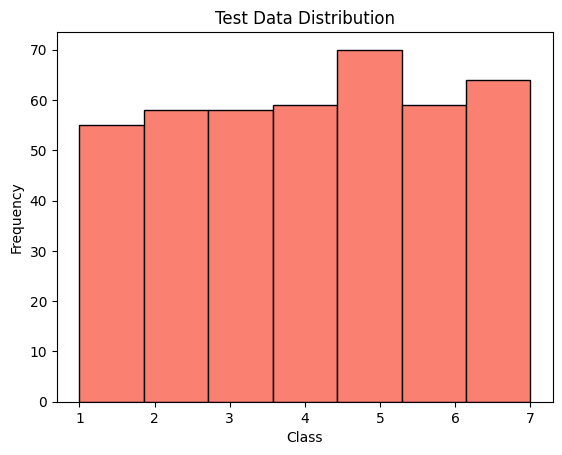

In [77]:
plt.figure()
plt.hist(y_test, bins = 7, color = 'salmon', edgecolor = 'black')
plt.title('Test Data Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [78]:
# Create a DataFrame from 'y_test_real'
df_y_test = pd.DataFrame({'y_test_real': y_test_real})

# Get value counts
value_counts_df = df_y_test['y_test_real'].value_counts()

# Print the results
print(value_counts_df)

# Create a DataFrame from 'y_test_real'
df_y_test = pd.DataFrame({'y_test_synt': y_test_synt})

# Get value counts
value_counts_df = df_y_test['y_test_synt'].value_counts()

# Print the results
print(value_counts_df)

y_test_real
2    58
3    12
4    12
5     9
1     7
6     2
Name: count, dtype: int64
y_test_synt
7    64
5    61
6    57
1    48
4    47
3    46
Name: count, dtype: int64


## 6. Models Development

### Data Scaling

In [79]:
from sklearn.preprocessing import StandardScaler

dataset_ = dataset_real.iloc[:,0:16]
col_list = list()
for column_name in dataset_.columns:
    col_list.append(column_name)
print(col_list)

scaler = StandardScaler()
print(scaler.fit(X_train))
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape[1])


['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
StandardScaler()
16


### 6.1. KNN Development

#### 6.1.1. Feature Extraction for KNN

In [40]:
x_range_KNN = np.linspace(1, 25, 25, dtype = int)
Acc_train_matr_KNN, F1_train_matr_KNN, Acc_test_matr_KNN, F1_test_matr_KNN, Voided_col_KNN = get_performace_on_grid(X_train_scaled, 
                                                                             y_train, X_test_scaled, 
                                                                             y_test, x_range_KNN, 'KNN')

Number of neighbors: 1
Number of neighbors: 2
Number of neighbors: 3
Number of neighbors: 4
Number of neighbors: 5
Number of neighbors: 6
Number of neighbors: 7
Number of neighbors: 8
Number of neighbors: 9
Number of neighbors: 10
Number of neighbors: 11
Number of neighbors: 12
Number of neighbors: 13
Number of neighbors: 14
Number of neighbors: 15
Number of neighbors: 16
Number of neighbors: 17
Number of neighbors: 18
Number of neighbors: 19
Number of neighbors: 20
Number of neighbors: 21
Number of neighbors: 22
Number of neighbors: 23
Number of neighbors: 24
Number of neighbors: 25


#### 6.1.2. Plot of Performance Metrics for KNN

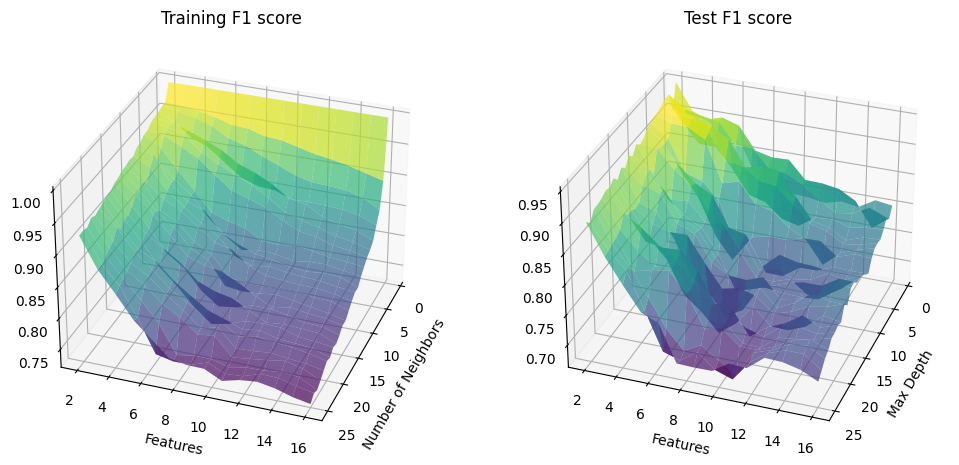

In [84]:
# Removing the first 1-2 rows of the performance matrix
# due to different scales of the calculated metric
# (for one feature, the performance is worse than for more features)
i_start = 2
y_range = np.linspace(2, Acc_train_matr_DT.shape[0], Acc_train_matr_DT.shape[0] - i_start)

fig = plt.figure(figsize = (12, 6))
# For F1 score
elev = 30
azim = 20

# For Error
elev = 30
#azim = -60

gs  = gridspec.GridSpec(1, 2, width_ratios = [1, 1])
ax1 = fig.add_subplot(gs[0], projection = '3d')
ax1.view_init(elev = elev, azim = azim)
plot_3d(ax1, F1_train_matr_KNN[i_start:], x_range_KNN, y_range, 'Training F1 score', 'Number of Neighbors')
#plot_3d(ax1, Acc_train_matr_KNN[i_start:], x_range_KNN, y_range, 'Training Error', 'Number of Neighbors', is_error = True)

ax2 = fig.add_subplot(gs[1], projection = '3d')
ax2.view_init(elev = elev, azim = azim)
plot_3d(ax2, F1_test_matr_KNN[i_start:], x_range_KNN, y_range, 'Test F1 score', 'Max Depth')
#plot_3d(ax2, F1_test_matr_KNN[i_start:], x_range_KNN, y_range, 'Test Error', 'Number of Neighbors', is_error = True)

plt.show()

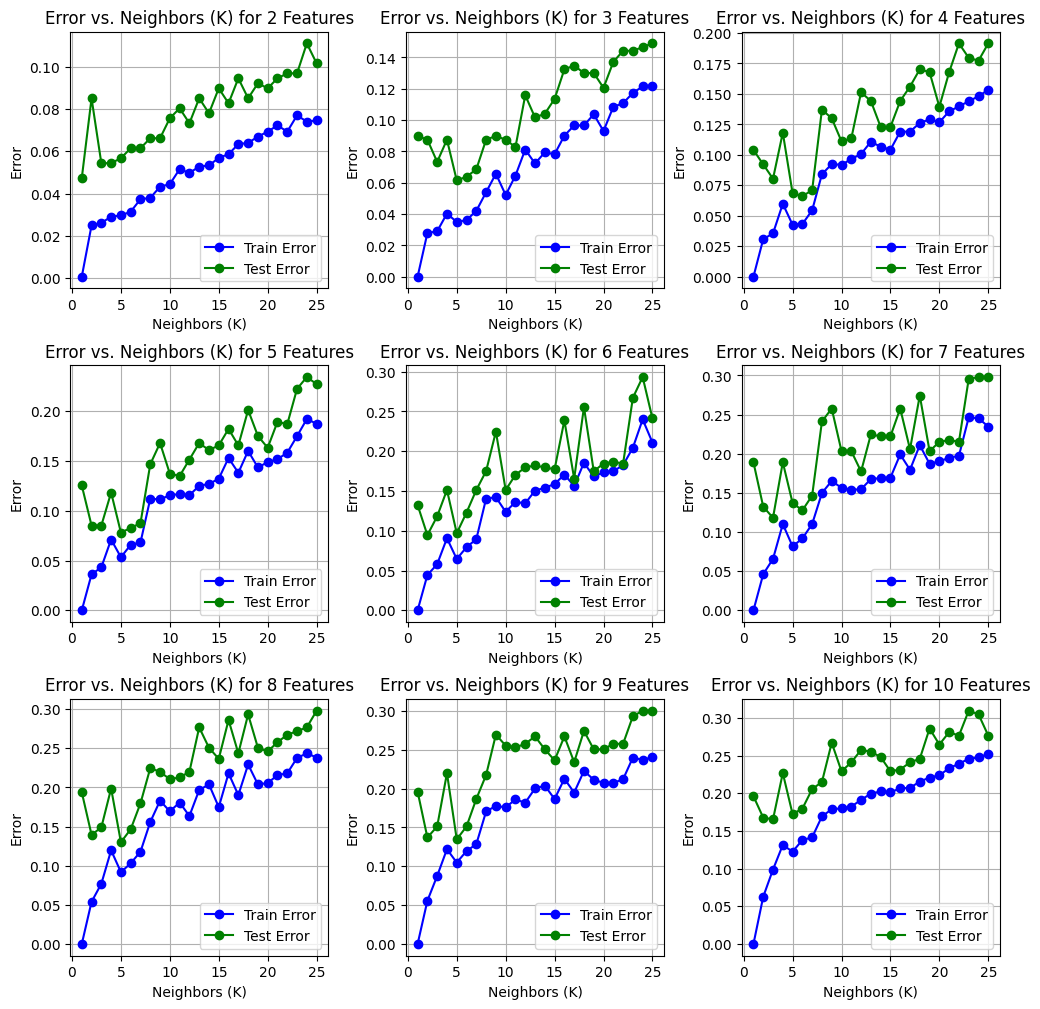

In [85]:
# Plot of 2D performance metric for the given number of features VS a number of neighbors in KNN.

plt.figure(figsize = (12,12))

row = 3
col = 3

for i in range(1, 10):
# For the KNN model
    plot_performance_metric(row, col, i, Acc_train_matr_KNN, Acc_test_matr_KNN, x_range_KNN, 'Error', i + 1, 'Neighbors (K)', 4)

plt.subplots_adjust(hspace = 0.3, wspace = 0.3)  # Increase the value to increase spacing
plt.show()

#### KNN
For the n_neigbors = 3, we have the following most importante features:
3 features: 1 - Gender, 2 - Height, 3 - Weight
5 features: 1 - Gender, 2 - Height, 3 - Weight, 4 - FAVC, 5 - SCC

For the n_neigbors = 5, we have the following most importante features:
3 features: 1 - Gender, 2 - Height, 3 - Weight
5 features: 1 - Gender, 2 - Height, 3 - Weight, 4 - SMOKE, 5 - SCC

#### 6.1.3. The Performance of the Best KNN Models and their Ensemble

In [86]:
# The section is used for KNN ensemble’s prediction using the four best predictors
# for i_neighbors in [3, 5] and i_features in [3, 5]

y_pred = np.array([])
for i_neighbors in [3, 5]:
    print('Feature extraction for K =', i_neighbors, 'neighbors using the Backward stepwise algorithm')
    dict_of_params_KNN = {'n_neighbors': i_neighbors}
    df_train, df_test = feature_extraction(X_train_scaled, y_train, X_test_scaled, y_test,'KNN', dict_of_params_KNN)
    for i_features in [3, 5]:
        return_list = features_list(col_list, df_train['voided_column'].tolist(), i_features)
        X_train_i, X_test_i = get_matrices(i_features, X_train_scaled, X_test_scaled, df_train['voided_column'].tolist())
        print(return_list)
        model = KNeighborsClassifier(n_neighbors = i_neighbors)
        model.fit(X_train_i, y_train)
        if y_pred.shape[0] == 0:
            y_pred = model.predict(X_test_i)
        else:
            y_pred = np.column_stack((y_pred, model.predict(X_test_i)))
        clf_performance(model, X_test_i, y_test, is_print = True)    
#y_pred = y_pred.T

Feature extraction for K = 3 neighbors using the Backward stepwise algorithm
['Gender' 'Height' 'Weight']
Accuracy = 0.9456
F1 = 0.9440
Confusion matrix:
[[54  1  0  0  0  0  0]
 [ 5 50  3  0  0  0  0]
 [ 0  1 54  3  0  0  0]
 [ 0  0  6 52  1  0  0]
 [ 0  0  0  1 68  1  0]
 [ 0  0  0  0  1 58  0]
 [ 0  0  0  0  0  0 64]]
['Gender' 'Height' 'Weight' 'FAVC' 'SCC']
Accuracy = 0.9314
F1 = 0.9288
Confusion matrix:
[[55  0  0  0  0  0  0]
 [ 6 46  6  0  0  0  0]
 [ 0  6 51  1  0  0  0]
 [ 0  1  5 52  1  0  0]
 [ 0  0  0  1 68  1  0]
 [ 0  0  0  0  1 58  0]
 [ 0  0  0  0  0  0 64]]
Feature extraction for K = 5 neighbors using the Backward stepwise algorithm
['Gender' 'Height' 'Weight']
Accuracy = 0.9456
F1 = 0.9438
Confusion matrix:
[[55  0  0  0  0  0  0]
 [ 6 49  3  0  0  0  0]
 [ 0  1 53  4  0  0  0]
 [ 0  0  5 53  1  0  0]
 [ 0  0  0  1 68  1  0]
 [ 0  0  0  0  1 58  0]
 [ 0  0  0  0  0  0 64]]
['Gender' 'Height' 'Weight' 'SMOKE' 'SCC']
Accuracy = 0.9314
F1 = 0.9287
Confusion matrix:
[[55

In [87]:
# Compute majority vote
m_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis = 1, arr = y_pred)
print(m_vote)

[7 1 5 5 2 1 3 4 5 3 6 7 3 1 7 2 3 7 1 7 7 1 3 2 1 4 7 5 4 5 6 1 1 7 2 1 4
 1 6 1 7 7 5 5 3 2 4 4 6 7 7 7 4 6 1 7 4 6 5 5 2 1 6 6 4 7 3 6 1 5 5 6 7 3
 1 4 3 3 5 7 3 2 2 4 4 1 4 2 5 7 2 4 7 3 7 5 4 6 3 5 1 2 3 1 4 7 6 6 5 6 1
 4 3 7 5 5 3 7 2 1 3 2 1 2 6 1 5 7 1 5 7 5 7 4 2 3 7 6 4 4 2 5 7 4 7 7 7 1
 3 4 4 6 4 4 3 3 3 5 3 6 2 6 7 5 1 3 6 3 5 4 5 5 5 2 2 7 1 3 7 5 5 4 1 5 5
 6 2 2 2 5 4 2 2 3 1 5 4 5 3 6 7 6 7 2 4 6 2 7 5 2 2 1 4 5 6 6 3 5 6 4 1 5
 5 7 4 1 7 3 4 5 1 5 7 7 6 7 5 1 5 5 7 2 4 1 3 3 4 2 5 3 3 5 3 4 3 6 7 6 1
 6 1 4 7 6 4 2 4 6 4 3 7 5 6 3 3 4 1 2 5 5 6 5 5 3 6 2 4 1 6 3 7 3 2 6 1 2
 7 7 2 7 3 1 5 6 1 3 6 3 5 2 1 7 7 1 2 1 5 6 3 5 1 2 2 7 6 5 6 6 7 5 5 3 3
 1 5 2 3 5 1 2 1 2 5 4 3 7 3 2 6 3 6 3 1 1 5 7 5 1 3 7 5 1 3 6 7 2 3 4 6 3
 1 1 7 5 6 4 3 2 6 4 4 6 1 2 6 2 5 1 7 2 5 2 6 6 2 5 2 2 1 1 1 6 7 7 4 4 7
 6 1 4 3 2 6 6 6 5 3 7 1 3 4 3 4]


In [66]:
clf_performance(model, X_test_i, y_test, is_print = True, y_pred = m_vote)

Accuracy = 0.9409
F1 = 0.9388
Confusion matrix:
[[55  0  0  0  0  0  0]
 [ 6 49  3  0  0  0  0]
 [ 0  4 53  1  0  0  0]
 [ 0  1  6 51  1  0  0]
 [ 0  0  0  1 68  1  0]
 [ 0  0  0  0  1 58  0]
 [ 0  0  0  0  0  0 64]]


(0.9408983451536643, 0.9388289857146833)

### 6.2. Decision Tree Model

#### 6.2.1. The First Decision Tree Model

In [ ]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

In [ ]:
# Define hyperparameter grid
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5],  # Adjust as needed
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  # Adjust as needed
}

# Initialize Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(criterion = 'entropy')

# Initialize PCA
pca = PCA()

# Perform grid search
grid_search = GridSearchCV(dt_classifier, param_grid, cv = project_folds)
#grid_search.fit(X_train_pca, y_train)
grid_search.fit(X_train_scaled, y_train)

# Get best hyperparameters
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_max_depth = grid_search.best_params_['max_depth']

print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Best max_depth: {best_max_depth}")


In [ ]:
pca = PCA(n_components = 16)

# Fit and transform the data
model_DT_PCA = DecisionTreeClassifier(min_samples_leaf = best_min_samples_leaf, max_depth = best_max_depth, random_state = project_random_state)
#model_DT_PCA.fit(X_train_pca, y_train)
#clf_performance(model_DT_PCA, X_test_pca, y_test, is_print = True)

model_DT_PCA.fit(X_train_scaled, y_train)
clf_performance(model_DT_PCA, X_test_scaled, y_test, is_print = True)

#### 6.2.2. Feature Extraction of a Decision Tree Model

In [82]:
x_range_DT = np.linspace(10, 50, 21, dtype = int)
Acc_train_matr_DT, F1_train_matr_DT, Acc_test_matr_DT, F1_test_matr_DT, Voided_col_DT = get_performace_on_grid(X_train_scaled, 
                                                                          y_train, X_test_scaled, 
                                                                          y_test, x_range_DT, 'DT')

Max depth: 10
Max depth: 12
Max depth: 14
Max depth: 16
Max depth: 18
Max depth: 20
Max depth: 22
Max depth: 24
Max depth: 26
Max depth: 28
Max depth: 30
Max depth: 32
Max depth: 34
Max depth: 36
Max depth: 38
Max depth: 40
Max depth: 42
Max depth: 44
Max depth: 46
Max depth: 48
Max depth: 50


#### 6.2.3. Plot of Performance Metrics of a Decision Tree in the Hyperparameter Space

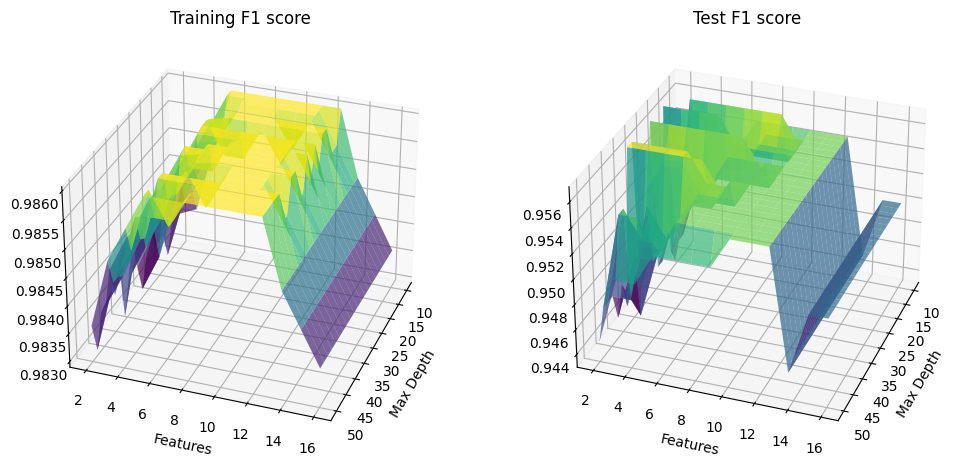

In [88]:
# Removing the first 1-2 rows of the performance matrix
# due to different scales of the calculated metric
# (for one feature, the performance is worse than for more features)
i_start = 3
y_range = np.linspace(2, Acc_train_matr_DT.shape[0], Acc_train_matr_DT.shape[0] - i_start)

# For KNN
#y_range = np.linspace(1, Acc_train_matr_KNN.shape[0], Acc_train_matr_KNN.shape[0])

fig = plt.figure(figsize = (12, 6))
elev = 30
azim = 20
gs  = gridspec.GridSpec(1, 2, width_ratios = [1, 1])
ax1 = fig.add_subplot(gs[0], projection = '3d')
ax1.view_init(elev = elev, azim = azim)
plot_3d(ax1, F1_train_matr_DT[i_start:], x_range_DT, y_range, 'Training F1 score', 'Max Depth')
#plot_3d(ax1, Acc_train_matr_DT[1:], x_range_DT, y_range, 'Training Error', 'Max Depth', is_error = True)

ax2 = fig.add_subplot(gs[1], projection = '3d')
ax2.view_init(elev = elev, azim = azim)
plot_3d(ax2, F1_test_matr_DT[i_start:], x_range_DT, y_range, 'Test F1 score', 'Max Depth')
#plot_3d(ax2, Acc_test_matr_DT[1:], x_range_DT, y_range, 'Test Error', 'Max Depth', is_error = True)

plt.show()

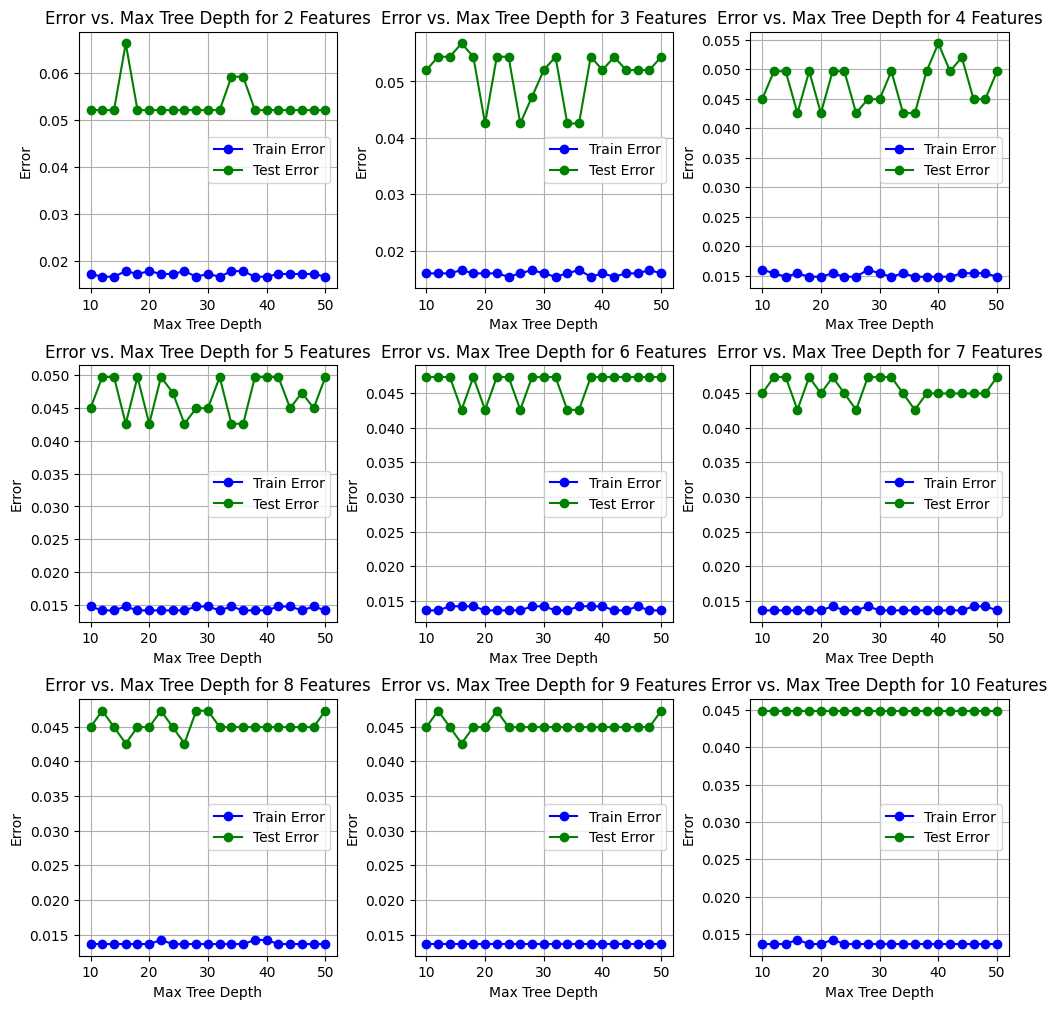

In [89]:
# Plot of 2D performance metric for the given number of features VS a tree depth (for Decision Tree).

plt.figure(figsize = (12,12))

row = 3
col = 3

for i in range(1, 10):
# For the decision tree model
    plot_performance_metric(row, col, i, Acc_train_matr_DT, Acc_test_matr_DT, x_range_DT, 'Error', i + 1, 'Max Tree Depth', 5)

plt.subplots_adjust(hspace = 0.3, wspace = 0.3)  # Increase the value to increase spacing
plt.show()

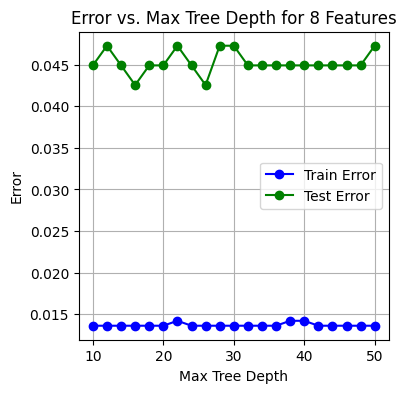

In [90]:
plt.figure(figsize = (4,4))
plot_performance_metric(1, 1, 1, Acc_train_matr_DT, Acc_test_matr_DT, x_range_DT, 'Error', 8, 'Max Tree Depth', 5)

#### 6.2.4. Obtaining the Best Decision Tree Model and Performance 

In [91]:
def find_closest_with_index(arr, target):
    lst = list(arr)
    closest = min(lst, key = lambda x: abs(x - target))
    index = lst.index(closest)
    return closest, index

In [92]:
max_depth = 20
closest_number, closest_index = find_closest_with_index(x_range_DT, max_depth)
dict_of_params_DT = {'min_samples_leaf': 3, 'max_depth': max_depth}
n_features = 8
#print(Voided_col_DT[:,closest_index])
features_list_DT = features_list(col_list, Voided_col_DT[:,closest_index], n_features)
print(features_list_DT)
X_train_i, X_test_i = get_matrices(n_features, X_train_scaled, X_test_scaled, Voided_col_DT[:,closest_index].tolist())

['Gender' 'Height' 'Weight' 'family_history_with_overweight' 'CH2O' 'SCC'
 'CALC' 'MTRANS']


In [93]:
model = DT_fitting(X_train_i, y_train, min_samples_leaf = 3, max_depth = max_depth)
clf_performance(model, X_test_i, y_test, is_print = True)

Accuracy = 0.9551
F1 = 0.9546
Confusion matrix:
[[54  1  0  0  0  0  0]
 [ 1 54  3  0  0  0  0]
 [ 0  2 53  3  0  0  0]
 [ 0  0  3 55  1  0  0]
 [ 0  0  0  1 69  0  0]
 [ 0  0  0  0  4 55  0]
 [ 0  0  0  0  0  0 64]]


(0.9550827423167849, 0.954625789492756)

### 6.3. Logistic Regression Model Development

#### 6.3.1. Feature Extraction For Logistic Regression
According to the plot of Train and Test error, the optimal number of features is 9:
1 - Gender, 2 - Age, 3 - Height, 4 - Weight, 5 - family_history_with_overweight, 6 - FAVC, 7 - CH2O, 8 - SCC, 9 - MTRANS

In [94]:
hyper_C = 1
iters = 300
dict_of_params_LR = {'max_iter': iters, 'C': hyper_C}
df_train, df_test = feature_extraction(X_train_scaled, y_train, X_test_scaled, y_test,'LR', dict_of_params_LR)

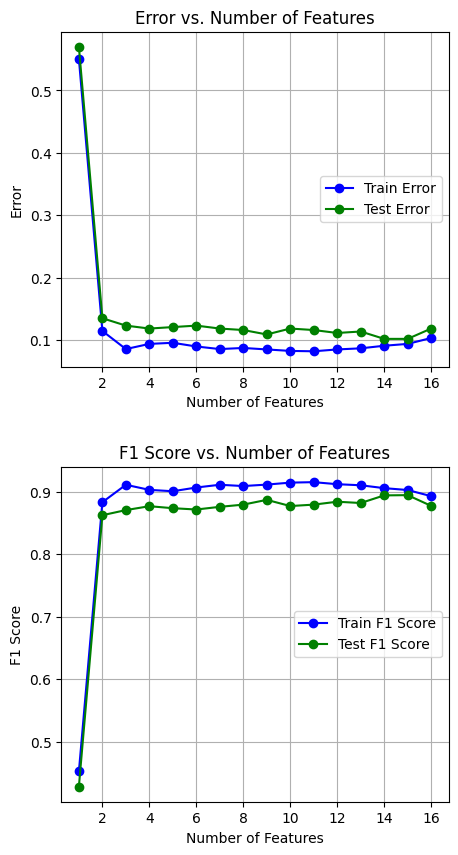

In [95]:
def add_axis(df_column):
    column_array = df_column.to_numpy()[::-1]
    column_vector = column_array[:, np.newaxis]
    column_vector = np.transpose(column_vector)
    return column_vector
    
plt.figure(figsize = (5, 10))

row = 2
col = 1

Acc_train_matr_LR = add_axis(df_train['acc'])
F1_train_matr_LR  = add_axis(df_train['f1'])
Acc_test_matr_LR  = add_axis(df_test['acc'])
F1_test_matr_LR   = add_axis(df_test['f1'])

x_range_LR = list(range(1, Acc_train_matr_LR.shape[1] + 1))

plot_performance_metric(row, col, 1, Acc_train_matr_LR, Acc_test_matr_LR, x_range_LR, 'Error', 0, 'Number of Features', 5)
plot_performance_metric(row, col, 2, F1_train_matr_LR, F1_test_matr_LR, x_range_LR, 'F1 Score', 0, 'Number of Features', 5)

plt.subplots_adjust(hspace = 0.3, wspace = 0.3)  # Increase the value to increase spacing
plt.show()

In [96]:
n_features = 9
features_list_LR = features_list(col_list, df_train['voided_column'].tolist(), n_features, is_print = True)
X_train_i, X_test_i = get_matrices(n_features, X_train_scaled, X_test_scaled, df_train['voided_column'].tolist())
print()
print('The set of', n_features, 'features:')
print(features_list_LR)

['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
['Gender' 'Age' 'Height' 'Weight' 'family_history_with_overweight' 'FAVC'
 'FCVC' 'NCP' 'CAEC' 'SMOKE' 'CH2O' 'SCC' 'FAF' 'CALC' 'MTRANS']
['Gender' 'Age' 'Height' 'Weight' 'family_history_with_overweight' 'FAVC'
 'FCVC' 'NCP' 'CAEC' 'SMOKE' 'CH2O' 'SCC' 'CALC' 'MTRANS']
['Gender' 'Age' 'Height' 'Weight' 'family_history_with_overweight' 'FAVC'
 'FCVC' 'NCP' 'SMOKE' 'CH2O' 'SCC' 'CALC' 'MTRANS']
['Gender' 'Age' 'Height' 'Weight' 'family_history_with_overweight' 'FAVC'
 'FCVC' 'SMOKE' 'CH2O' 'SCC' 'CALC' 'MTRANS']
['Gender' 'Age' 'Height' 'Weight' 'family_history_with_overweight' 'FAVC'
 'FCVC' 'CH2O' 'SCC' 'CALC' 'MTRANS']
['Gender' 'Age' 'Height' 'Weight' 'family_history_with_overweight' 'FAVC'
 'FCVC' 'CH2O' 'SCC' 'MTRANS']
['Gender' 'Age' 'Height' 'Weight' 'family_history_with_overweight' 'FAVC'
 'CH2O' 'SCC' 'MTRANS']
['Gender

#### 6.3.2. Learning Curve for Logistic Regression

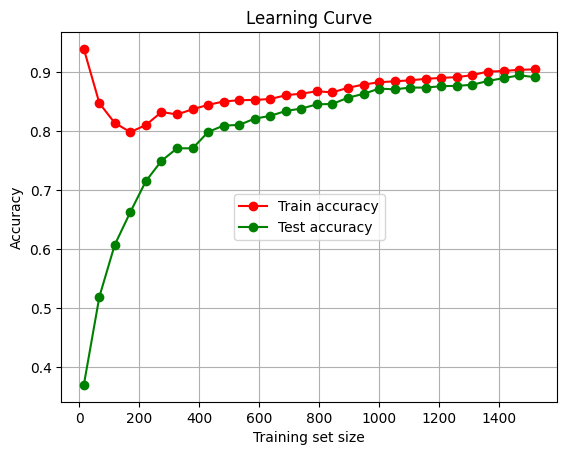

In [97]:
model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C = hyper_C, max_iter = iters)
#model = KNeighborsClassifier(n_neighbors = 5)
kfold_LR = KFold(n_splits = project_folds, shuffle = True, random_state = project_random_state)
train_sizes, train_scores, valid_scores = learning_curve(model, X_train_i, y_train, train_sizes = np.linspace(0.01, 1.0, 30),
                                                         cv = kfold_LR, scoring = 'accuracy')
train_errors = train_scores.mean(axis=1)
valid_errors = valid_scores.mean(axis=1)
plt.plot(train_sizes, train_errors, marker = 'o', linestyle = '-', color = 'r', label = "Train accuracy")
plt.plot(train_sizes, valid_errors, marker = 'o', linestyle = '-', color = 'g', label = "Test accuracy")
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc = 10)
plt.grid(True)
plt.show()

In [98]:
scores = cross_val_score(model, X_train_i, y_train, cv = project_folds, scoring = 'accuracy')

# Print the mean and standard deviation of the scores
print(f"Mean scoring: {np.mean(scores):.4f}")
print(f"Standard deviation: {np.std(scores):.4f}")

Mean scoring: 0.8880
Standard deviation: 0.0197


#### 6.3.3. Grid Search for Logistic Regression

In [99]:
model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 1.2],
              'max_iter': [160, 180, 200]}
clf = GridSearchCV(model, param_grid, scoring = 'accuracy', cv = project_folds)
clf.fit(X_train_i, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 1.2],
                         'max_iter': [160, 180, 200]},
             scoring='accuracy')

In [100]:
clf.best_params_

{'C': 1.2, 'max_iter': 160}

#### 6.3.4. Fitting the Logistic Regression Model and Obtaining Performance Metrics

In [101]:
best_C = clf.best_params_['C']
best_iter = clf.best_params_['max_iter']
#model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C = best_C, max_iter = best_iter)
#model.fit(X_train_i, y_train)

In [102]:
model_LR = LR_fitting(X_train_i, y_train, best_C, best_iter)
clf_performance(model_LR, X_test_i, y_test, is_print = True)

Accuracy = 0.9054
F1 = 0.9017
Confusion matrix:
[[54  1  0  0  0  0  0]
 [ 7 44  7  0  0  0  0]
 [ 0  2 48  8  0  0  0]
 [ 0  0 10 46  3  0  0]
 [ 0  0  0  0 68  2  0]
 [ 0  0  0  0  0 59  0]
 [ 0  0  0  0  0  0 64]]


(0.9054373522458629, 0.9016641654561196)

### 6.4. Support Vector Classifier Development

#### 6.4.1. The First Support Vector Classifier
The first SVC uses all the features. 

In [368]:
clf_SVC_simple = SVC(kernel = 'linear')
clf_SVC_simple.fit(X_train_scaled, y_train)
clf_performance(clf_SVC_simple, X_test_scaled, y_test, is_print = True)

Accuracy = 0.9409
F1 = 0.9385
Confusion matrix:
[[54  1  0  0  0  0  0]
 [ 7 49  2  0  0  0  0]
 [ 0  3 52  3  0  0  0]
 [ 0  0  6 52  1  0  0]
 [ 0  0  0  1 68  1  0]
 [ 0  0  0  0  0 59  0]
 [ 0  0  0  0  0  0 64]]


(0.9408983451536643, 0.938519289824909)

In [323]:
model_SVC = SVC(kernel = 'linear')
#param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 1.2],
#              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#             }
#param_grid = {'C': [1, 1.2, 1.4, 1.6, 1.8, 2.0],
#              'kernel': ['linear', 'poly'],
#             }
param_grid = {'C': [1, 1.5, 2.0, 2.5, 3.0],
              'kernel': ['linear'],
             }
#param_grid = {'C': [1, 1.5, 2.0, 2.5, 3.0],
#              'kernel': ['rbf'],
#              'gamma': [0.5, 1, 1.5]
#             }
#param_grid = {'C': [1, 1.5, 2.0, 2.5, 3.0],
#              'kernel': ['poly'],
#              'degree': [1, 2, 3, 4, 5]
#             }
clf_SVC = GridSearchCV(model_SVC, param_grid, scoring = 'accuracy', cv = project_folds)
clf_SVC.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=SVC(kernel='linear'),
             param_grid={'C': [1, 1.5, 2.0, 2.5, 3.0], 'kernel': ['linear']},
             scoring='accuracy')

In [326]:
clf_SVC.best_params_

{'C': 2.0, 'kernel': 'linear'}

In [316]:
clf_SVC.n_features_in_

16

In [325]:
clf_performance(clf_SVC, X_test_scaled, y_test, is_print = True)

Accuracy = 0.9409
F1 = 0.9384
Confusion matrix:
[[55  0  0  0  0  0  0]
 [ 7 48  3  0  0  0  0]
 [ 0  4 52  2  0  0  0]
 [ 0  0  6 52  1  0  0]
 [ 0  0  0  1 68  1  0]
 [ 0  0  0  0  0 59  0]
 [ 0  0  0  0  0  0 64]]


(0.9408983451536643, 0.9384489141895778)

#### 6.4.2. Feature Extraction for Support Vector Classifier
The space of hyperparameters: C and number of features.

In [103]:
x_range_SVC = np.linspace(1, 3, 21)
Acc_train_matr_SVC, F1_train_matr_SVC, Acc_test_matr_SVC, F1_test_matr_SVC, Voided_col_SVC = get_performace_on_grid(X_train_scaled, 
                                                                             y_train, X_test_scaled, 
                                                                             y_test, x_range_SVC, 'SVC')

C: 1.0
C: 1.1
C: 1.2
C: 1.3
C: 1.4
C: 1.5
C: 1.6
C: 1.7000000000000002
C: 1.8
C: 1.9
C: 2.0
C: 2.1
C: 2.2
C: 2.3
C: 2.4000000000000004
C: 2.5
C: 2.6
C: 2.7
C: 2.8
C: 2.9000000000000004
C: 3.0


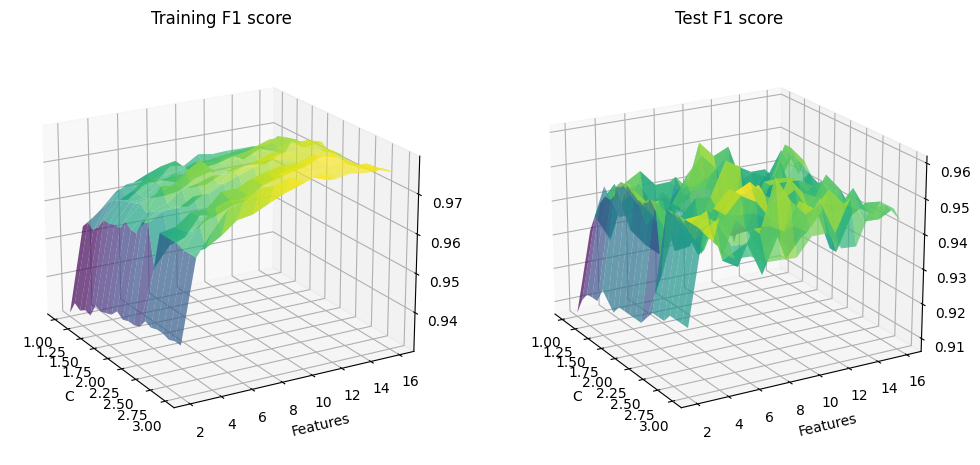

In [104]:
# Removing the first 1-2 rows of the performance matrix
# due to different scales of the calculated metric
# (for one feature, the performance is worse than for more features)
i_start = 1
y_range = np.linspace(2, Acc_train_matr_SVC.shape[0], Acc_train_matr_SVC.shape[0] - i_start)

# For KNN
#y_range = np.linspace(1, Acc_train_matr_KNN.shape[0], Acc_train_matr_KNN.shape[0])

fig = plt.figure(figsize = (12, 6))
elev = 20
azim = -30
gs  = gridspec.GridSpec(1, 2, width_ratios = [1, 1])
ax1 = fig.add_subplot(gs[0], projection = '3d')
ax1.view_init(elev = elev, azim = azim)
plot_3d(ax1, F1_train_matr_SVC[i_start:], x_range_SVC, y_range, 'Training F1 score', 'C')
#plot_3d(ax1, Acc_train_matr_SVC[1:], x_range_SVC, y_range, 'Training Error', 'C', is_error = True)

ax2 = fig.add_subplot(gs[1], projection = '3d')
ax2.view_init(elev = elev, azim = azim)
plot_3d(ax2, F1_test_matr_SVC[i_start:], x_range_SVC, y_range, 'Test F1 score', 'C')
#plot_3d(ax2, Acc_test_matr_SVC[1:], x_range_SVC, y_range, 'Test Error', 'C', is_error = True)

plt.show()

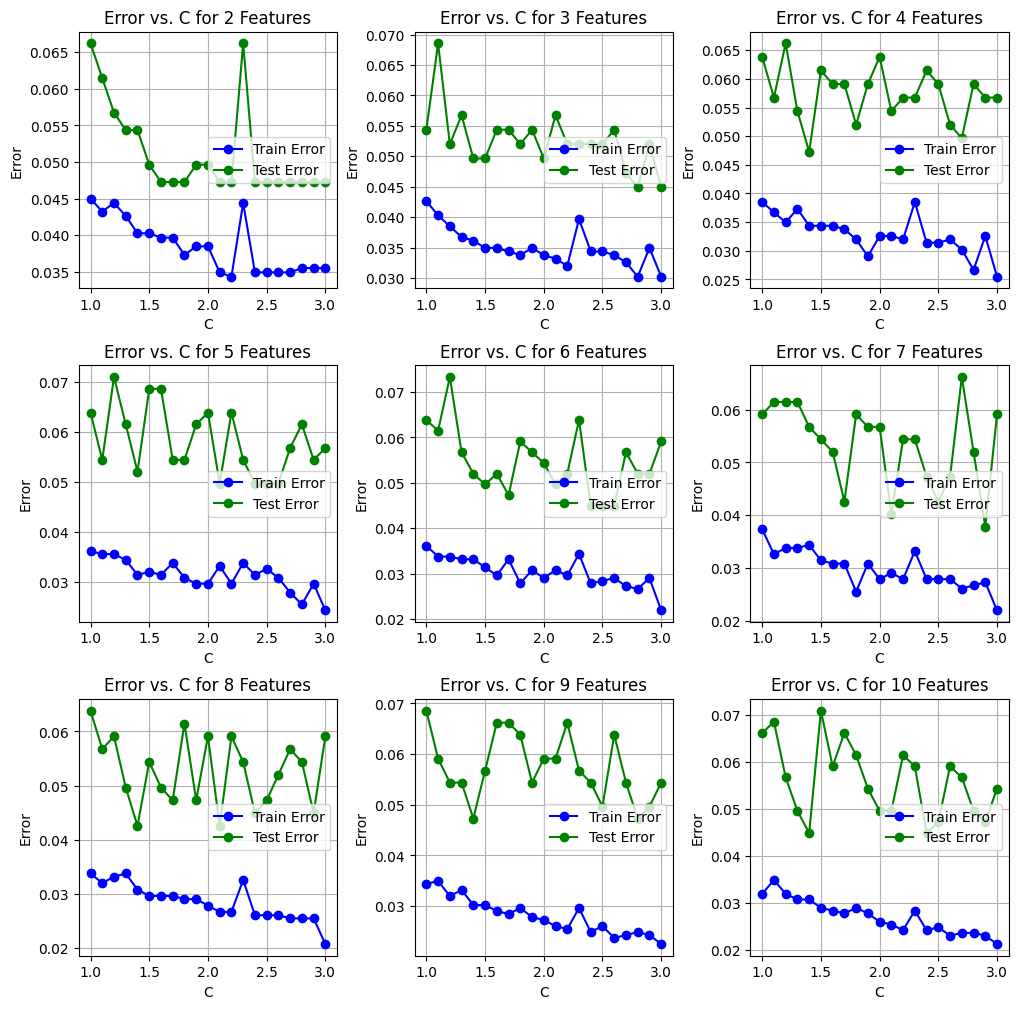

In [105]:
# Plot of 2D performance metric for the given number of features VS a tree depth (for Decision Tree).

plt.figure(figsize = (12,12))

row = 3
col = 3

for i in range(1, 10):
# For the decision tree model
    plot_performance_metric(row, col, i, Acc_train_matr_SVC, Acc_test_matr_SVC, x_range_SVC, 'Error', i + 1, 'C', 5)

plt.subplots_adjust(hspace = 0.3, wspace = 0.3)  # Increase the value to increase spacing
plt.show()

#### 6.3.4. Fitting the Best Support Vector Classifier and Obtaining Performance Metrics

In [106]:
hyper_C = 1.7
closest_number, closest_index = find_closest_with_index(x_range_SVC, hyper_C)
dict_of_params_SVC = {'C': hyper_C}
n_features = 6
#print(Voided_col_DT[:,closest_index])
features_list_SVC = features_list(col_list, Voided_col_SVC[:,closest_index], n_features)
print(features_list_SVC)
X_train_i, X_test_i = get_matrices(n_features, X_train_scaled, X_test_scaled, Voided_col_SVC[:,closest_index].tolist())

['Gender' 'Height' 'Weight' 'family_history_with_overweight' 'FAVC' 'CALC']


In [107]:
model_SVC = SVC(kernel = 'linear', C = hyper_C)
model_SVC.fit(X_train_i, y_train)

SVC(C=1.7, kernel='linear')

In [108]:
clf_performance(model_SVC, X_test_i, y_test, is_print = True)

Accuracy = 0.9456
F1 = 0.9436
Confusion matrix:
[[55  0  0  0  0  0  0]
 [ 7 48  3  0  0  0  0]
 [ 0  2 55  1  0  0  0]
 [ 0  0  6 52  1  0  0]
 [ 0  0  0  0 69  1  0]
 [ 0  0  0  0  2 57  0]
 [ 0  0  0  0  0  0 64]]


(0.9456264775413712, 0.9436372231668599)